<a href="https://colab.research.google.com/github/Duhuhruv/ECE570-DrQSnake/blob/main/DrQ_Snake_Rev4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DrQ-based Snake Reinforcement Learning Agent

This notebook implements two reinforcement learning approaches for the Snake game:

1. **Vanilla DQN:** A standard Deep Q-Network without data augmentation.
2. **DrQ:** A data-regularized Q-learning method that applies random shift augmentation.

You can control which method to run by setting `USE_AUGMENTATION`:
  - `USE_AUGMENTATION = False` for Vanilla DQN
  - `USE_AUGMENTATION = True` for DrQ

Also, use the **QUICK_MODE** flag for a smoke test (fewer training steps) before running a full training session.

The notebook logs key metrics, plots learning curves, saves those plots to Google drive or whever else specified.

In [17]:
# --- Configuration and Setup ---

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# --- Configuration Flags ---
QUICK_MODE = True   # Set to False for full training

# Flag to control data augmentation:
# Set USE_AUGMENTATION = True for DrQ (with random shift augmentation)
# Set USE_AUGMENTATION = False for Vanilla DQN (no augmentation)
USE_AUGMENTATION = True

if QUICK_MODE:
    MAX_STEPS = 50_000       # Fewer steps for a smoke test
    EPS_DECAY_STEPS = 2000   # Faster epsilon decay for quick mode
    PRINT_EVERY = 50         # More frequent logging
else:
    MAX_STEPS = 500_000      # Full training run
    EPS_DECAY_STEPS = 100000
    PRINT_EVERY = 100

# Hyperparameters
OBS_SIZE = 84         # Observation image size (84x84)
GRID_SIZE = 12        # Snake game grid (12x12)
FRUIT_REWARD = 3     # Reward for eating fruit
DEATH_REWARD = -1.0   # Reward for dying
SURVIVAL_REWARD = 0.005  # Small reward per step for survival
BATCH_SIZE = 128
BUFFER_CAPACITY = 50_000
GAMMA = 0.99
LR = 1e-3
TARGET_UPDATE_TAU = 0.01   # Polyak averaging factor
INITIAL_RANDOM_STEPS = 5000  # Steps to collect before training


Using device: cpu


## 1. Define the Snake Environment

The following class defines the Snake game on a 12×12 grid. The game state is returned as an 84×84 grayscale image. The `reset()` method initializes the game, and the `step(action)` method updates the snake's state based on the chosen action (0: up, 1: right, 2: down, 3: left).

### Reward Shaping

A reward‐shaping term has been added so that, in addition to the standard rewards, the agent receives a bonus if its new head position is closer to the fruit (based on the Manhattan distance) and a penalty if it moves farther away.

In [18]:
class SnakeEnv:
    def __init__(self, grid_size=GRID_SIZE, obs_size=OBS_SIZE):
        self.grid_size = grid_size
        self.obs_size = obs_size
        self.cell_size = obs_size // grid_size
        # grayscale values 0-255
        self.background_val = 0    # black
        self.snake_val = 170       # gray
        self.fruit_val = 255       # white
        # Actions: 0: up, 1: right, 2: down, 3: left
        self.actions = {
            0: (-1, 0),
            1: (0, 1),
            2: (1, 0),
            3: (0, -1)
        }
        self.reset()

    def reset(self):
        """Reset the game and return the initial observation."""
        init_len = 3
        r = c = self.grid_size // 2
        self.snake = [(r, c - i) for i in range(init_len)]  # horizontal snake, head at (r, c)
        self.direction = (0, 1)  # initially moving right
        self._place_fruit()
        self.steps = 0
        self.done = False
        return self._get_observation()

    def _place_fruit(self):
        snake_set = set(self.snake)
        free_cells = [(i, j) for i in range(self.grid_size) for j in range(self.grid_size) if (i, j) not in snake_set]
        self.fruit = random.choice(free_cells) if free_cells else None

    def _get_observation(self):
        """Return the current game state."""
        grid = np.full((self.grid_size, self.grid_size), self.background_val, dtype=np.uint8)
        for (r, c) in self.snake:
            grid[r, c] = self.snake_val
        if self.fruit is not None:
            fr, fc = self.fruit
            grid[fr, fc] = self.fruit_val
        # Upsample the grid by repeating each cell value
        obs_img = np.repeat(np.repeat(grid, self.cell_size, axis=0), self.cell_size, axis=1)
        return obs_img

    def step(self, action):
        """
        Take an action (0=up, 1=right, 2=down, 3=left).
        Returns: next_obs, reward, done, info.
        """
        if self.done:
            return self._get_observation(), 0.0, True, {}

        self.steps += 1
        reward = 0.0
        dr, dc = self.actions[action]
        cur_dr, cur_dc = self.direction
        # Prevent reversal if snake has more than one segment
        if len(self.snake) > 1 and (dr, dc) == (-cur_dr, -cur_dc):
            # Ignore reverse by using the current direction instead of the reverse
            dr, dc = cur_dr, cur_dc
        self.direction = (dr, dc)

        head_r, head_c = self.snake[0]
        new_head = (head_r + dr, head_c + dc)
        nr, nc = new_head

        # Check for wall collision
        if nr < 0 or nr >= self.grid_size or nc < 0 or nc >= self.grid_size:
            reward = DEATH_REWARD
            self.done = True
            return self._get_observation(), reward, True, {}

        # Check for self-collision
        if new_head in self.snake:
            tail = self.snake[-1]
            fruit_eaten = (new_head == self.fruit)
            if not (new_head == tail and not fruit_eaten):
                reward = DEATH_REWARD
                self.done = True
                return self._get_observation(), reward, True, {}

        # --- Reward Shaping: Incentivize moving toward the fruit ---
        if self.fruit is not None:
            fruit_r, fruit_c = self.fruit
            old_distance = abs(head_r - fruit_r) + abs(head_c - fruit_c)
            new_distance = abs(nr - fruit_r) + abs(nc - fruit_c)
            shaping_reward = 0.1 * (old_distance - new_distance)  # positive if moving closer
            reward += shaping_reward

        # --- Move Snake ---
        # Insert new head
        self.snake.insert(0, new_head)
        fruit_eaten = False
        if self.fruit is not None and new_head == self.fruit:
            fruit_eaten = True
            reward += FRUIT_REWARD
        else:
            self.snake.pop()  # remove tail if no fruit eaten

        if fruit_eaten:
            self._place_fruit()
        if self.fruit is None:
            self.done = True  # snake filled grid

        reward += SURVIVAL_REWARD
        obs = self._get_observation()
        return obs, reward, self.done, {}


### Quick Test: Visualize the Initial Game State

Run the following cell to create an instance of the environment and display the initial observation.

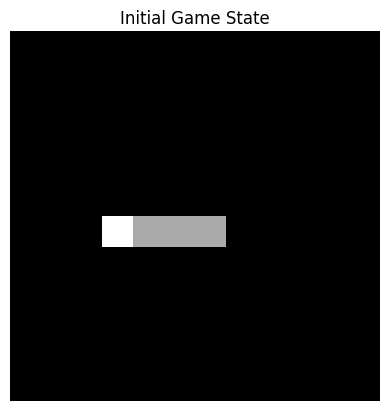

In [19]:
# Create environment instance and display initial state
env = SnakeEnv()
obs = env.reset()
plt.imshow(obs, cmap='gray')
plt.title("Initial Game State")
plt.axis('off')
plt.show()


## 2. Replay Buffer with Optional Augmentation

The replay buffer stores transitions (state, action, reward, next_state, done). When sampling, it applies random shift augmentation **if** `USE_AUGMENTATION` is set to `True`. Setting this flag to `False` gives you a Vanilla DQN run.

In [20]:
class ReplayBuffer:
    def __init__(self, capacity, obs_shape):
        self.capacity = capacity
        self.obs_buf = np.empty((capacity, *obs_shape), dtype=np.uint8)
        self.next_obs_buf = np.empty((capacity, *obs_shape), dtype=np.uint8)
        self.actions = np.empty(capacity, dtype=np.int32)
        self.rewards = np.empty(capacity, dtype=np.float32)
        self.dones = np.empty(capacity, dtype=np.bool_)
        self.size = 0
        self.ptr = 0

    def add(self, obs, action, reward, next_obs, done):
        idx = self.ptr
        self.obs_buf[idx] = obs
        self.next_obs_buf[idx] = next_obs
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.dones[idx] = done
        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        indices = np.random.choice(self.size, batch_size, replace=False)
        obs_batch = self.obs_buf[indices].astype(np.float32) / 255.0
        next_obs_batch = self.next_obs_buf[indices].astype(np.float32) / 255.0
        actions_batch = torch.from_numpy(self.actions[indices]).to(device)
        rewards_batch = torch.from_numpy(self.rewards[indices]).to(device)
        dones_batch = torch.from_numpy(self.dones[indices].astype(np.float32)).to(device)
        obs_tensor = torch.from_numpy(obs_batch).unsqueeze(1).to(device)      # shape [B, 1, 84, 84]
        next_obs_tensor = torch.from_numpy(next_obs_batch).unsqueeze(1).to(device)

        if USE_AUGMENTATION:
            obs_aug = self._random_shift_batch(obs_tensor)
            next_obs_aug = self._random_shift_batch(next_obs_tensor)
        else:
            obs_aug = obs_tensor
            next_obs_aug = next_obs_tensor

        return obs_aug, actions_batch, rewards_batch, next_obs_aug, dones_batch

    def _random_shift_batch(self, img_batch, pad=4):
        B, C, H, W = img_batch.shape
        padded = F.pad(img_batch, pad=(pad, pad, pad, pad), mode='replicate')
        aug_batch = torch.empty_like(img_batch)
        for i in range(B):
            dh = random.randint(0, pad * 2)
            dw = random.randint(0, pad * 2)
            aug_batch[i] = padded[i, :, dh:dh + H, dw:dw + W]
        return aug_batch

# Initialize replay buffer
replay_buffer = ReplayBuffer(BUFFER_CAPACITY, (OBS_SIZE, OBS_SIZE))


## 3. Q-Network Architecture and Target Network

We define a CNN-based Q-network that takes an 84×84 grayscale image and outputs Q-values for each action via twin Q-heads. A target network is maintained using Polyak averaging to stabilize training.

In [21]:
class QNetwork(nn.Module):
    def __init__(self, action_dim):
        super(QNetwork, self).__init__()
        # Convolutional encoder
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=2), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, stride=2), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1), nn.ReLU()
        )
        with torch.no_grad():
            dummy = torch.zeros(1, 1, OBS_SIZE, OBS_SIZE)
            conv_out = self.conv(dummy).view(1, -1)
            conv_out_dim = conv_out.shape[1]
        self.fc = nn.Linear(conv_out_dim, 50)
        self.layer_norm = nn.LayerNorm(50)
        # Twin Q-heads
        self.q1 = nn.Sequential(nn.Linear(50, 128), nn.ReLU(), nn.Linear(128, action_dim))
        self.q2 = nn.Sequential(nn.Linear(50, 128), nn.ReLU(), nn.Linear(128, action_dim))

    def forward(self, x):
        h = self.conv(x)
        h = h.view(h.size(0), -1)
        h = self.fc(h)
        h = self.layer_norm(h)
        h = torch.tanh(h)
        q1_values = self.q1(h)
        q2_values = self.q2(h)
        return q1_values, q2_values

def update_target_network(source_net, target_net, tau=TARGET_UPDATE_TAU):
    for src_param, tgt_param in zip(source_net.parameters(), target_net.parameters()):
        tgt_param.data.copy_(tau * src_param.data + (1.0 - tau) * tgt_param.data)

# Initialize networks and optimizer
action_dim = len(SnakeEnv().actions)
q_network = QNetwork(action_dim).to(device)
target_network = QNetwork(action_dim).to(device)
target_network.load_state_dict(q_network.state_dict())
target_network.eval()

optimizer = torch.optim.Adam(q_network.parameters(), lr=LR)


## 4. Training Loop

This training loop uses epsilon-greedy exploration to collect experiences, stores them in the replay buffer, and performs training updates using batches of transitions. The Double DQN target is computed using the target network. Checkpoints are saved and metrics (episode rewards and training loss) are logged.

By setting `USE_AUGMENTATION` to `True` you run DrQ, and by setting it to `False` you run Vanilla DQN. You can run separate experiments and save the results for later comparison.

In [22]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [9]:
# Initialize training variables
num_episodes = 0
episode_reward = 0.0
episode_length = 0
state = env.reset()
total_steps = INITIAL_RANDOM_STEPS  # will fill initial experience first
save_path = "/content/drive/My Drive/Colab Notebooks/SnakeAI/RewardShaping3/"
epsilon = 1.0  # Initialize epsilon to 1.0 before random steps

# Populate initial replay buffer with random actions
print("Collecting initial experience...")
for _ in range(INITIAL_RANDOM_STEPS):
    action = random.randrange(action_dim)
    next_state, reward, done, _ = env.step(action)
    replay_buffer.add(state, action, reward, next_state, done)
    state = next_state
    if done:
        state = env.reset()

# Reset training counters
state = env.reset()
episode_rewards = []
episode_lengths = []
losses = []
max_q_list = []   # to store max Q-values from training updates

print("Starting training...")
while total_steps < MAX_STEPS:
    # Epsilon-greedy action selection
    if random.random() < epsilon:
        action = random.randrange(action_dim)
    else:
        state_tensor = torch.from_numpy(state.astype(np.float32) / 255.0).unsqueeze(0).unsqueeze(0).to(device)
        with torch.no_grad():
            q1, q2 = q_network(state_tensor)
            q_values = (q1 + q2) / 2.0
            action = int(torch.argmax(q_values, dim=1).item())

    next_state, reward, done, _ = env.step(action)
    replay_buffer.add(state, action, reward, next_state, done)
    state = next_state
    episode_reward += reward
    episode_length += 1
    total_steps += 1

    # Epsilon decay (only after initial random steps)
    if total_steps > INITIAL_RANDOM_STEPS and total_steps < EPS_DECAY_STEPS:
        epsilon = 1.0 - (1.0 - 0.1) * ((total_steps - INITIAL_RANDOM_STEPS) / (EPS_DECAY_STEPS - INITIAL_RANDOM_STEPS))
    elif total_steps >= EPS_DECAY_STEPS:
        epsilon = 0.1

    if done:
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        num_episodes += 1
        if num_episodes % PRINT_EVERY == 0:
            avg_reward = np.mean(episode_rewards[-PRINT_EVERY:]) if len(episode_rewards) >= PRINT_EVERY else np.mean(episode_rewards)
            recent_loss = losses[-PRINT_EVERY:] if len(losses) >= PRINT_EVERY else losses
            recent_max_q = max_q_list[-PRINT_EVERY:] if len(max_q_list) >= PRINT_EVERY else max_q_list
            avg_loss = np.mean(recent_loss) if recent_loss else 0.0
            avg_max_q = np.mean(recent_max_q) if recent_max_q else 0.0
            print(f"Episode {num_episodes}, Step {total_steps}, Avg Reward (last {PRINT_EVERY}): {avg_reward:.2f}, Epsilon: {epsilon:.2f}, Avg Loss (last {PRINT_EVERY} updates): {avg_loss:.3f}, Avg Max Q (last {PRINT_EVERY} updates): {avg_max_q:.3f}")
            # Save checkpoint
            torch.save(q_network.state_dict(), os.path.join(save_path, f"checkpoint_episode_{num_episodes}.pth"))
        state = env.reset()
        episode_reward = 0.0
        episode_length = 0

    # Training update
    if replay_buffer.size >= BATCH_SIZE:
        obs_aug, actions_batch, rewards_batch, next_obs_aug, dones_batch = replay_buffer.sample(BATCH_SIZE)
        q1_pred, q2_pred = q_network(obs_aug)
        q1_val = q1_pred.gather(1, actions_batch.unsqueeze(1).long()).squeeze(1)
        q2_val = q2_pred.gather(1, actions_batch.unsqueeze(1).long()).squeeze(1)
        with torch.no_grad():
            q1_next_online, q2_next_online = q_network(next_obs_aug)
            q_next_online_avg = (q1_next_online + q2_next_online) / 2.0
            current_max_q = q_next_online_avg.max().item()
            max_q_list.append(current_max_q)
            next_actions = torch.argmax(q_next_online_avg, dim=1, keepdim=True)
            q1_next_target, q2_next_target = target_network(next_obs_aug)
            q1_target_val = q1_next_target.gather(1, next_actions).squeeze(1)
            q2_target_val = q2_next_target.gather(1, next_actions).squeeze(1)
            min_q_target = torch.min(q1_target_val, q2_target_val)
            y = rewards_batch + GAMMA * (1.0 - dones_batch) * min_q_target
        loss = F.mse_loss(q1_val, y) + F.mse_loss(q2_val, y)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        update_target_network(q_network, target_network, tau=TARGET_UPDATE_TAU)

print("Training complete!")

# --- After training: Automatically save the learning curves ---
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(episode_rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.subplot(2, 1, 2)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Update step')
plt.ylabel('Loss')

plt.tight_layout()
plot_path = os.path.join(save_path, 'learning_curves.png')
plt.savefig(plot_path, dpi=300)
print(f"Learning curves saved to {plot_path}")
plt.show()

Starting training...


KeyboardInterrupt: 

## 5. Save Metrics to CSV

This cell saves the episode reward data to a CSV file, labeled according to the method being used (Vanilla DQN or DrQ). You can later load these files to compare the two approaches.

In [ ]:
import csv

method = "drq" if USE_AUGMENTATION else "vanilla"
csv_filename = f"{method}_metrics.csv"

with open(csv_filename, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Episode", "Episode_Reward"])
    for i, reward in enumerate(episode_rewards):
        writer.writerow([i + 1, reward])
print(f"Metrics saved to {csv_filename}")

NameError: name 'USE_AUGMENTATION' is not defined

## 6. Plotting Learning Curves

This cell plots the episode reward and training loss curves using the in-memory data.

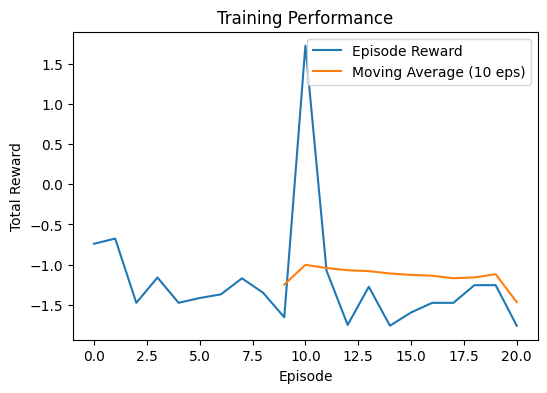

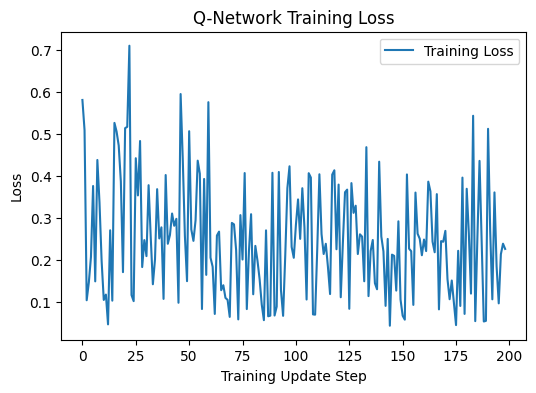

In [10]:
plt.figure(figsize=(6,4))
plt.plot(episode_rewards, label='Episode Reward')
if len(episode_rewards) > 0:
    window = max(10, len(episode_rewards)//20)
    smoothed = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, window-1+len(smoothed)), smoothed, label=f'Moving Average ({window} eps)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Performance')
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(losses, label='Training Loss')
plt.xlabel('Training Update Step')
plt.ylabel('Loss')
plt.title('Q-Network Training Loss')
plt.legend()
plt.show()

In [25]:
# --- Restore Training State ---
#checkpoint_path = "/content/drive/My Drive/Colab Notebooks/SnakeAI/RSTests/DQNFullscrewed.pth" #Full DQN harsh
#checkpoint_path = "/content/drive/My Drive/Colab Notebooks/SnakeAI/DrQ1/DrqFulltest2.pth" #Full DrQ harsh
#checkpoint_path = "/content/drive/My Drive/Colab Notebooks/SnakeAI/RewardShaping3/checkpoint_episode_5900.pth" # Full DQN test RS
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/SnakeAI/RewardShaping2/FinalDrQRSFull.pth"  # Full DrQ Test RS
q_network.load_state_dict(torch.load(checkpoint_path, map_location=device))
target_network.load_state_dict(q_network.state_dict())  # Sync target network

# Restore counters and epsilon
#num_episodes = 3250  # Update episode number
#total_steps = 500101  # Update total steps
#epsilon = 0.1  # Set epsilon for evaluation

print("Resumed from", checkpoint_path)
print("Starting from Episode:", num_episodes, "and Step:", total_steps)
episode_rewards = []  # Reset for evaluation
losses = []  # Reset if you want to track loss during further training

Resumed from /content/drive/My Drive/Colab Notebooks/SnakeAI/RewardShaping2/FinalDrQRSFull.pth
Starting from Episode: 21 and Step: 5199


Learning curves saved to /content/drive/My Drive/Colab Notebooks/SnakeAI/RewardShaping3/learning_curves1.png


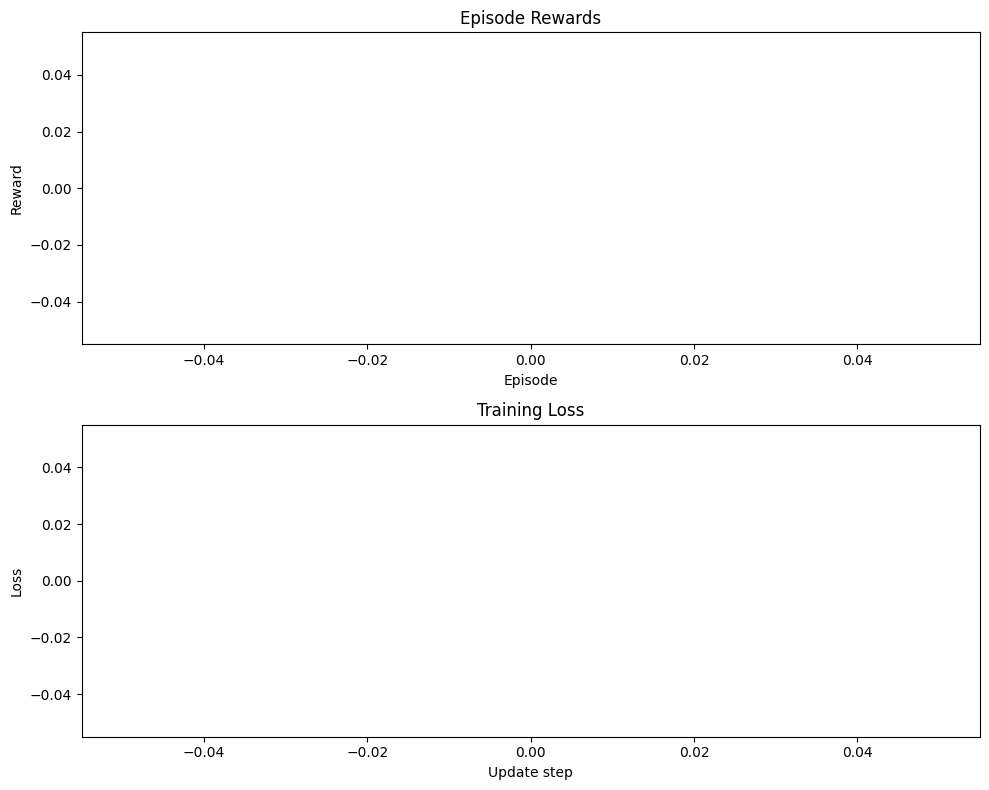

In [37]:
# Plot episode rewards and training loss
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(episode_rewards)
ax[0].set_title('Episode Rewards')
ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Reward')

ax[1].plot(losses)
ax[1].set_title('Training Loss')
ax[1].set_xlabel('Update step')
ax[1].set_ylabel('Loss')

plt.tight_layout()
# Automatically save the figure to Google Drive
plot_file = os.path.join(save_path, 'learning_curves1.png')
plt.savefig(plot_file, dpi=300)
print(f"Learning curves saved to {plot_file}")
plt.show()


## 7. Gameplay Visualization

This section runs one episode using the current (or reloaded) Q-network to visualize the snake in action. It displays the game state for a short time between steps so you can see how the snake behaves.

Starting gameplay visualization...
Episode finished after 183 steps, total reward: 31.71


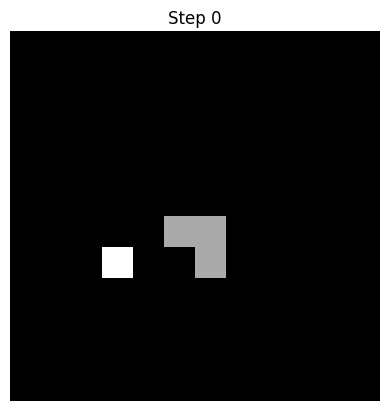

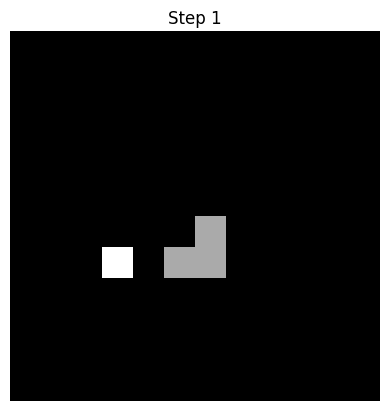

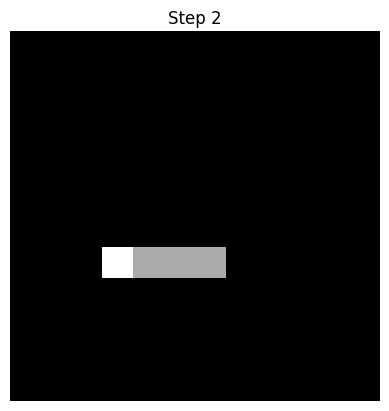

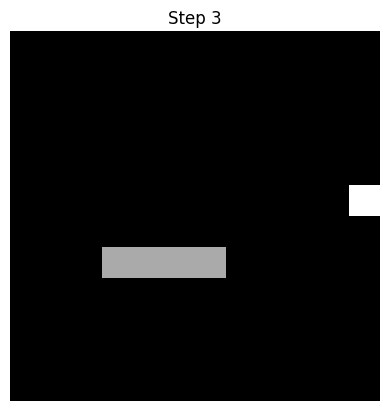

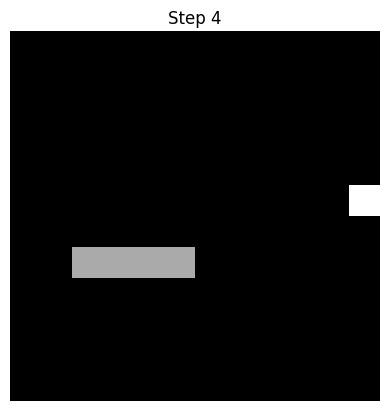

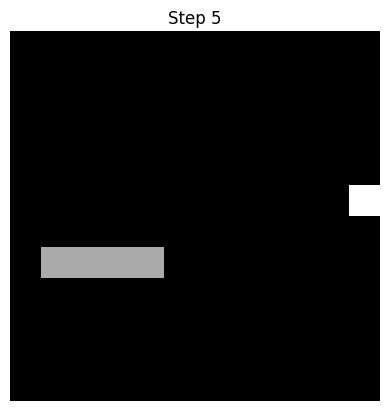

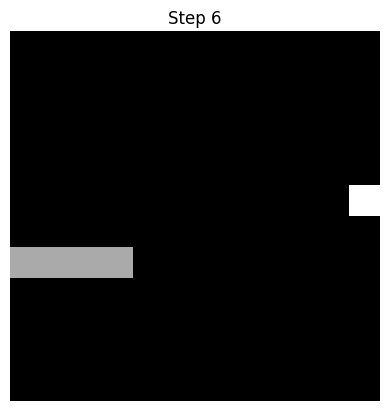

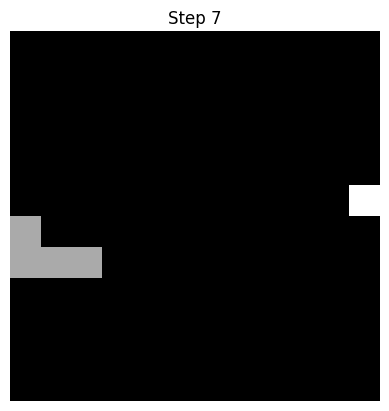

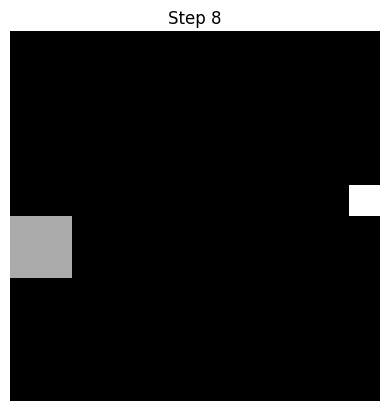

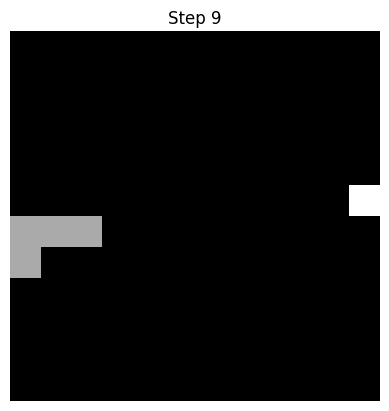

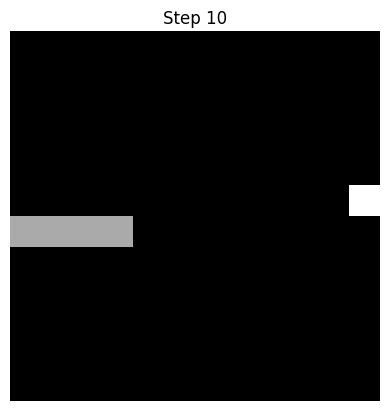

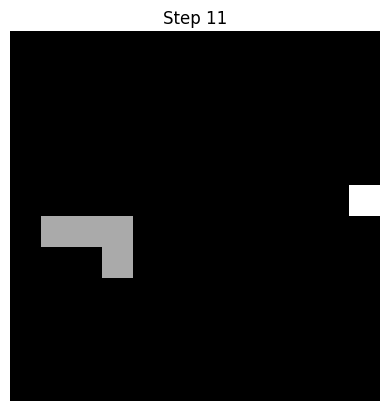

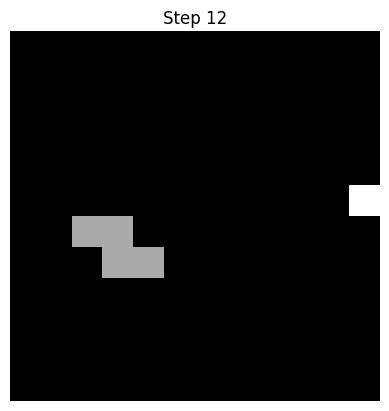

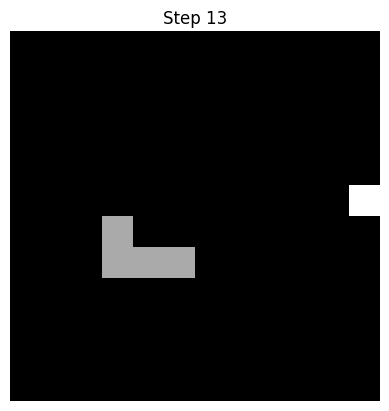

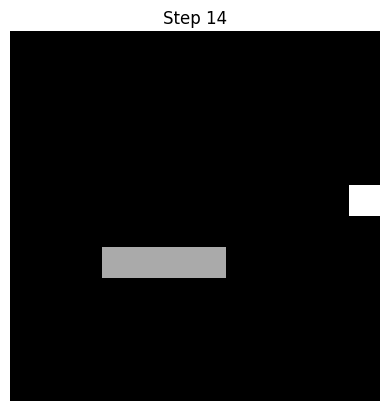

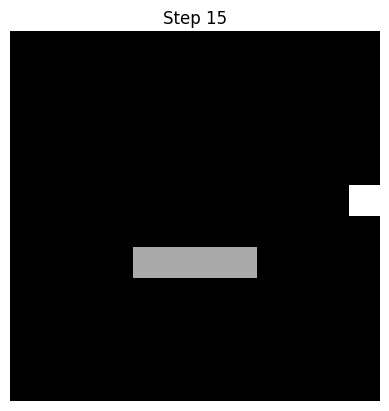

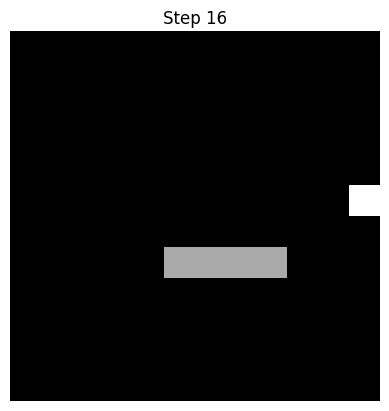

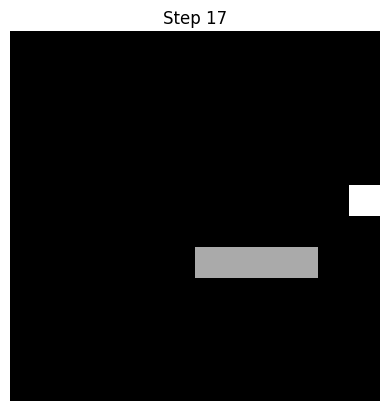

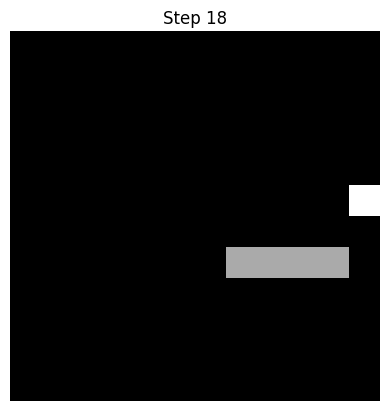

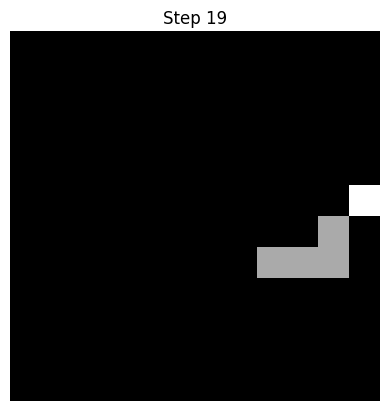

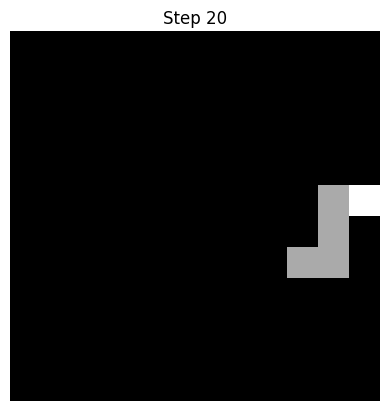

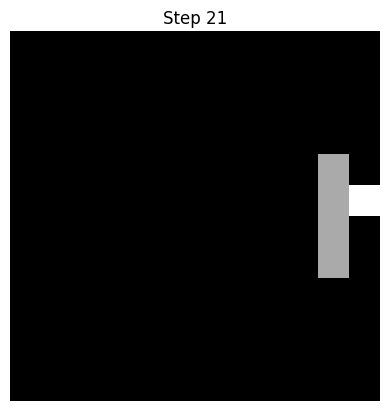

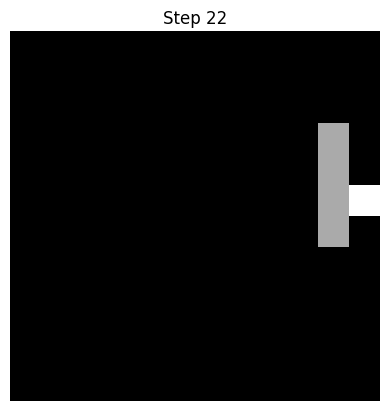

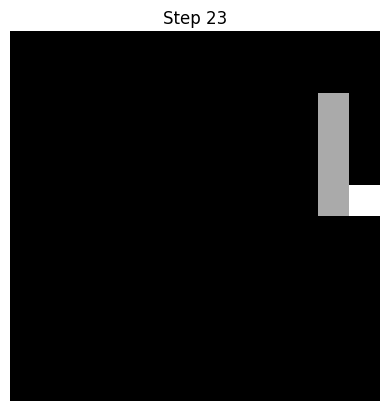

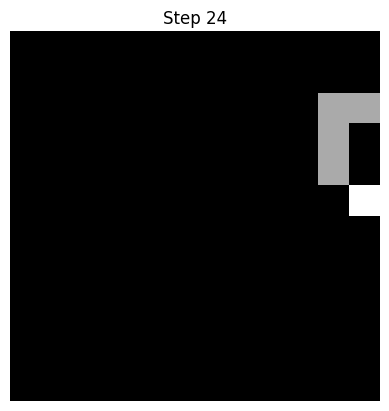

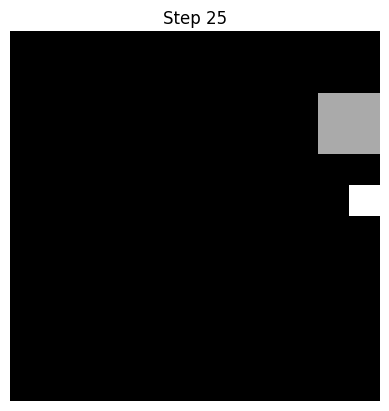

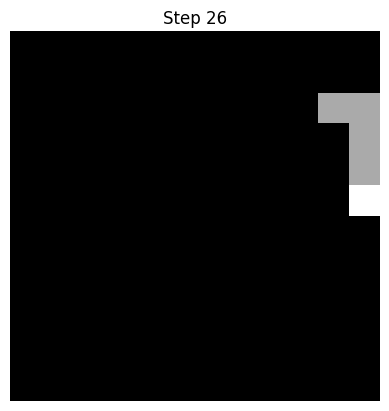

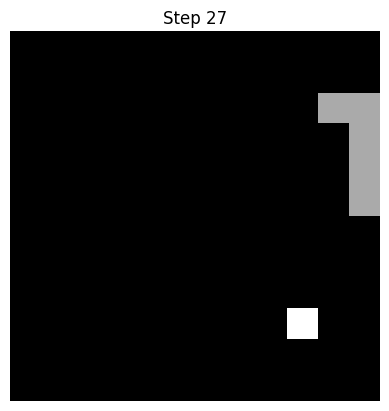

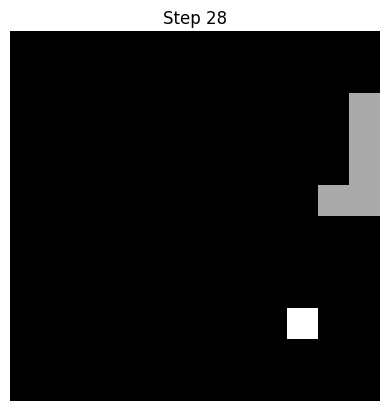

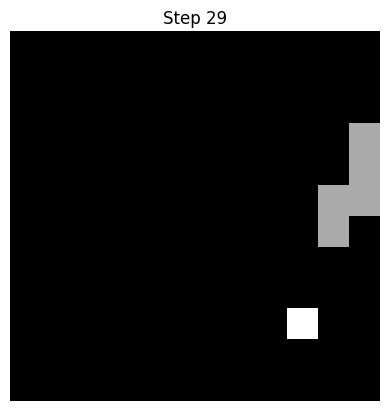

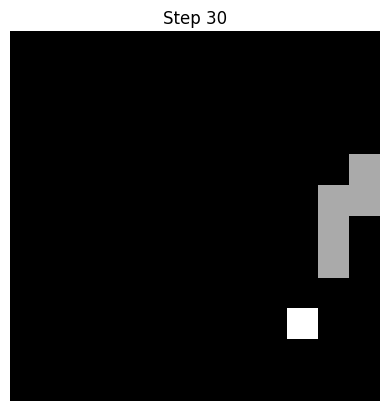

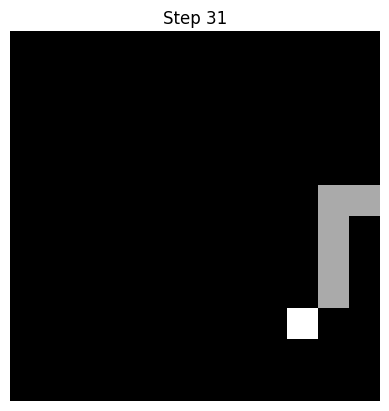

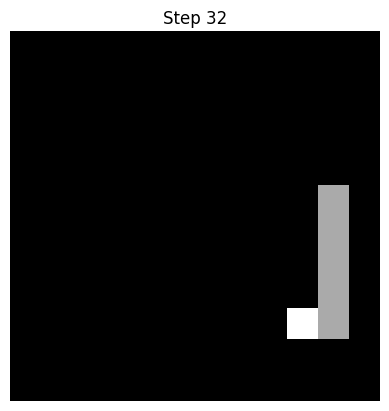

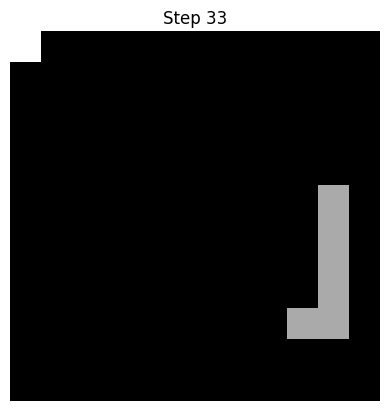

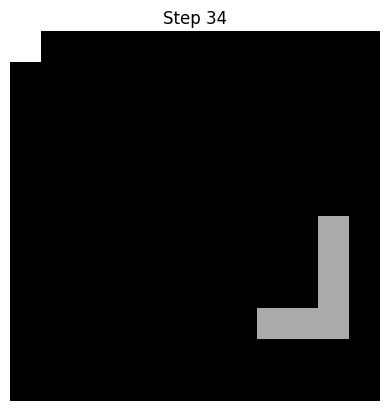

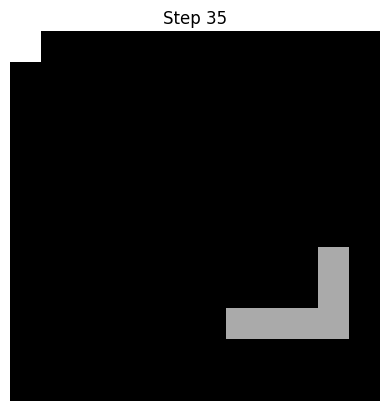

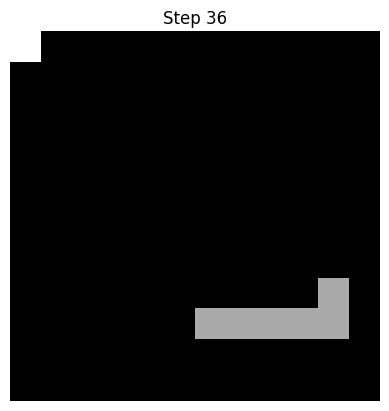

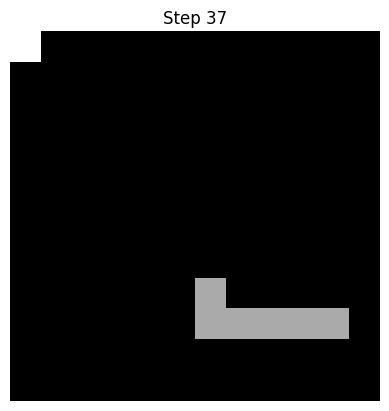

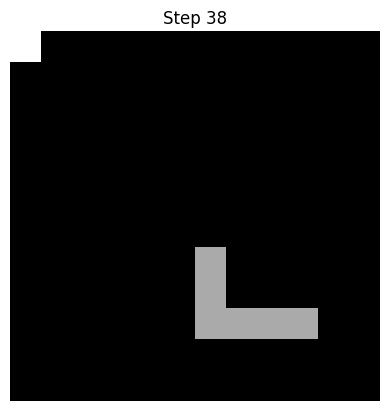

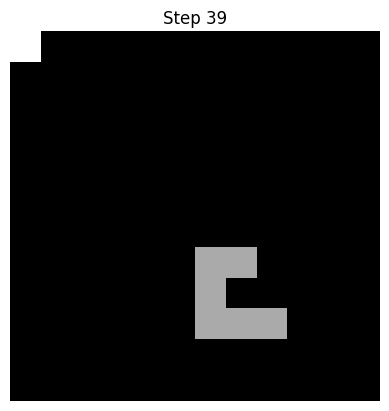

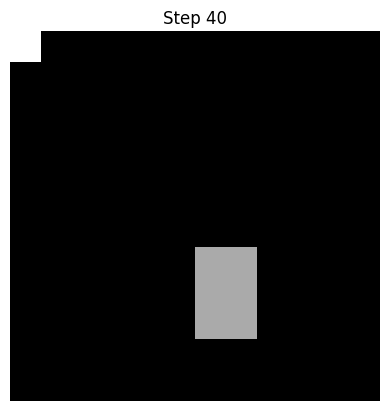

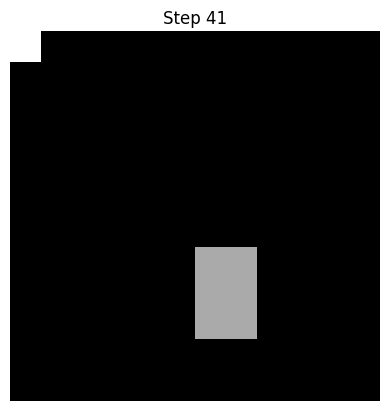

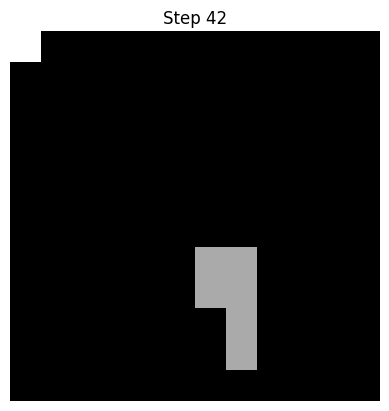

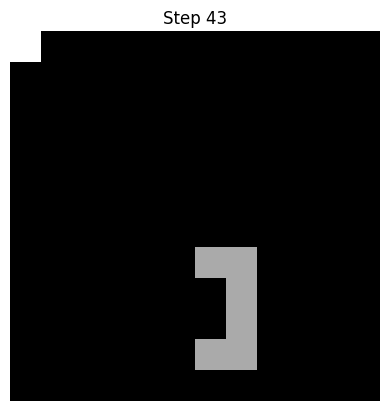

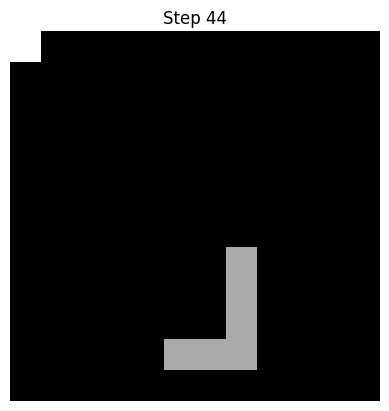

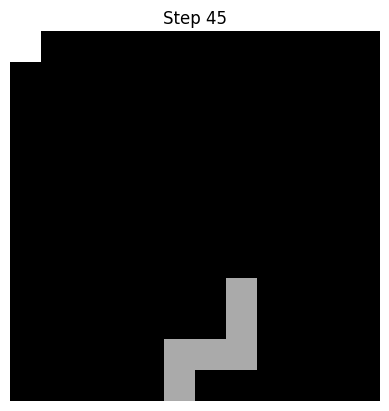

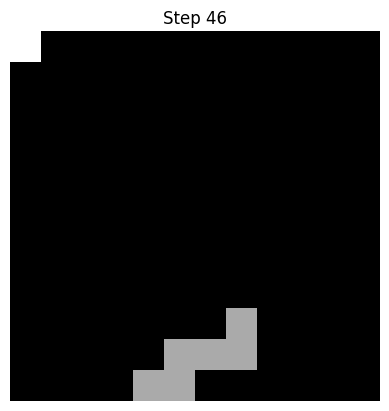

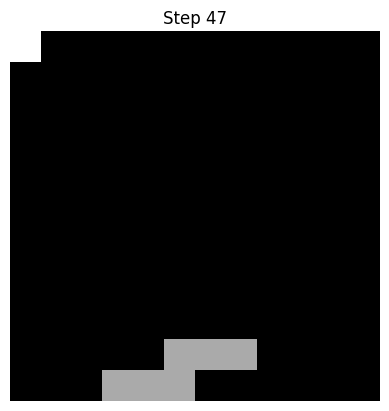

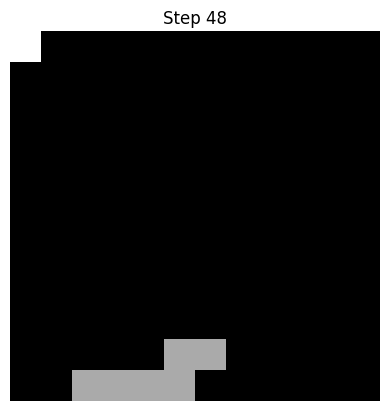

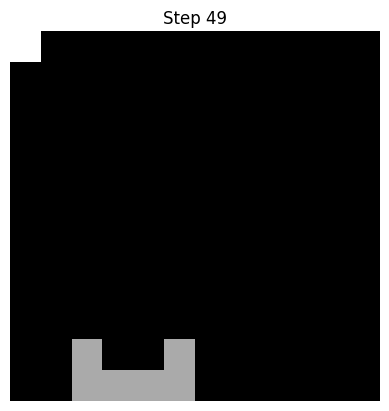

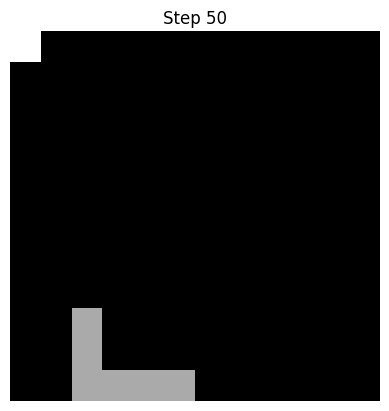

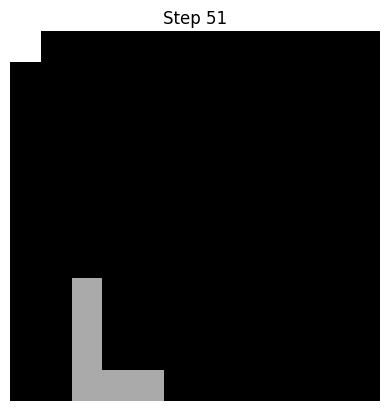

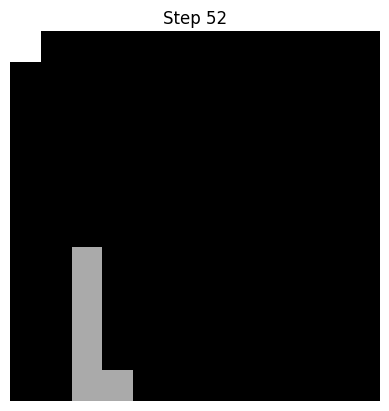

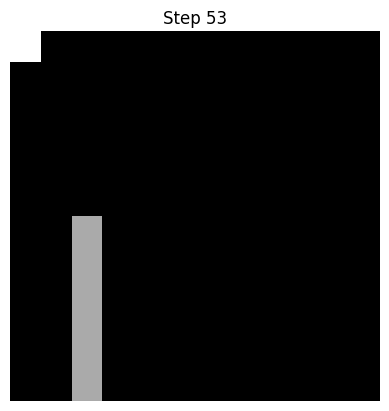

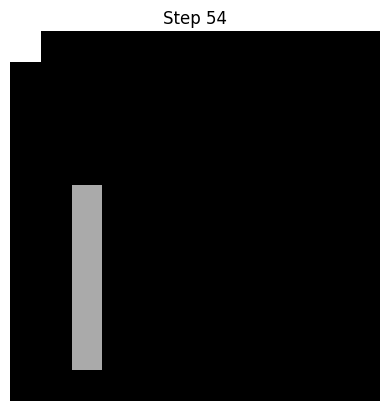

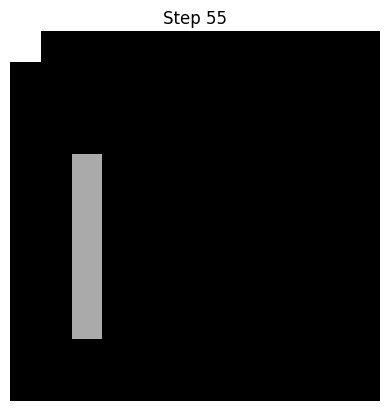

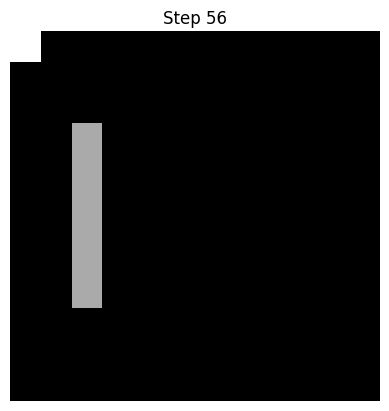

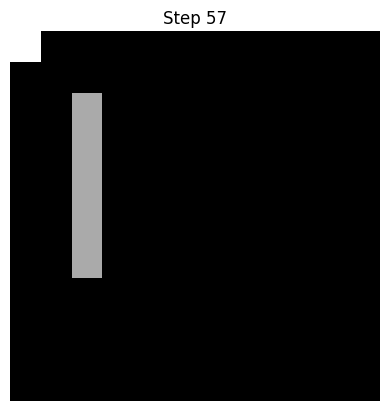

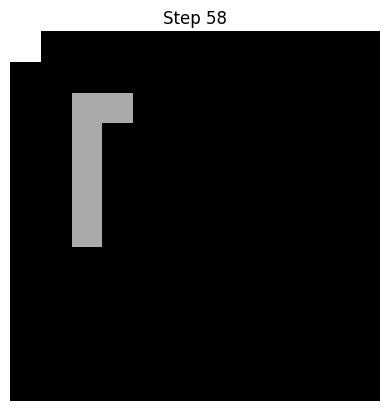

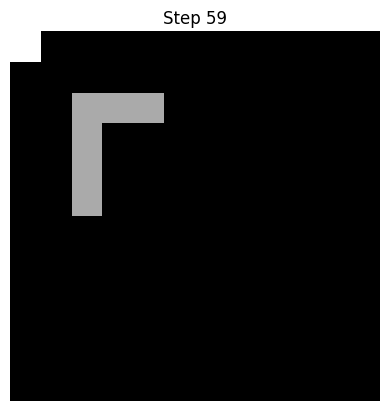

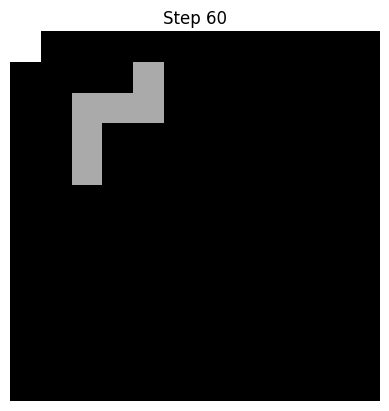

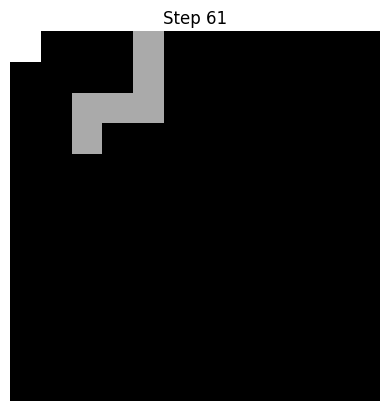

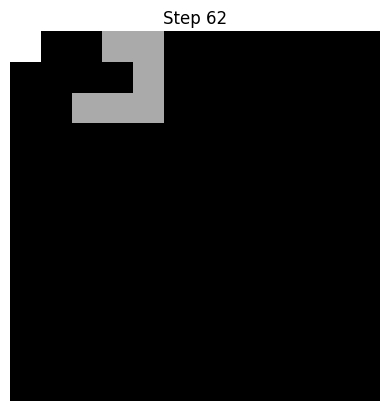

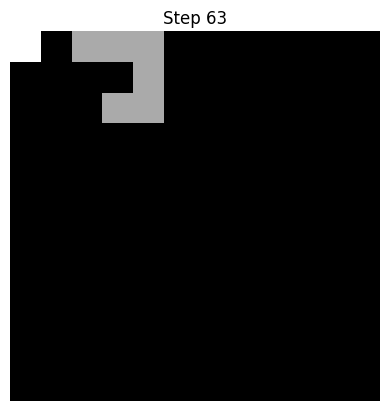

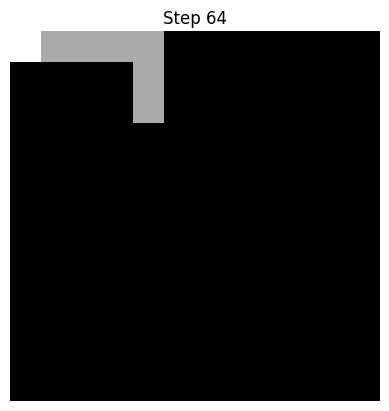

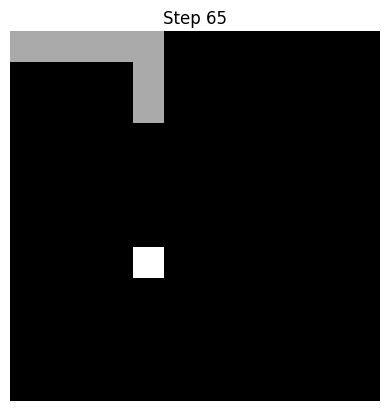

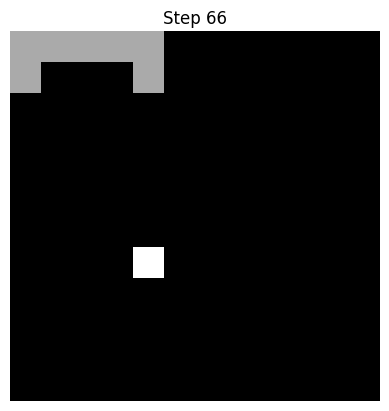

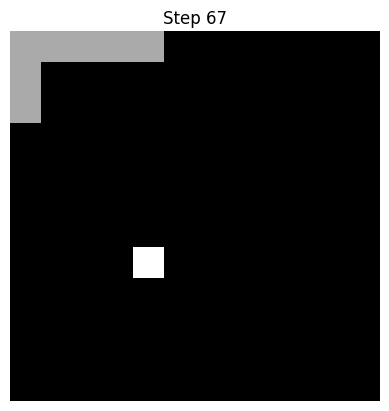

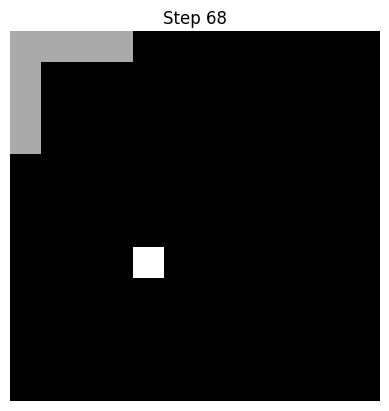

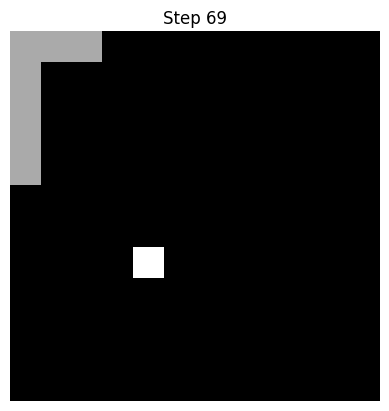

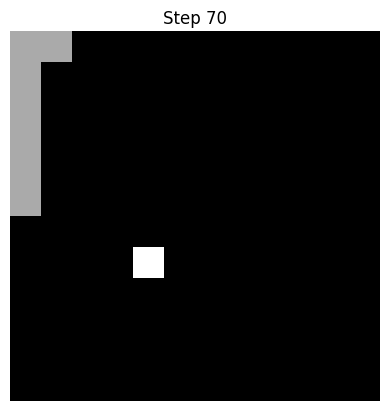

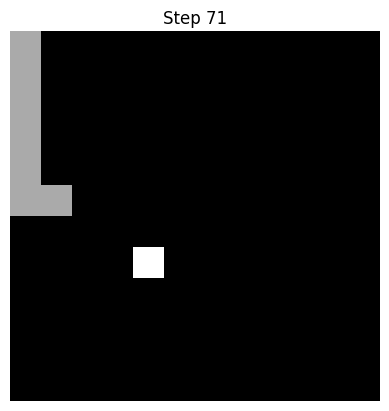

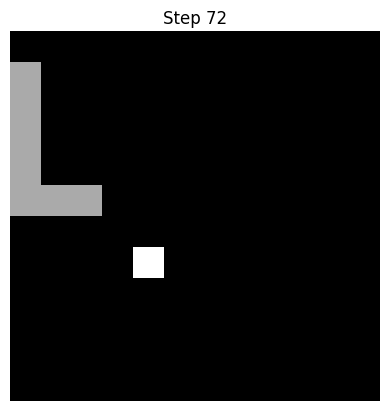

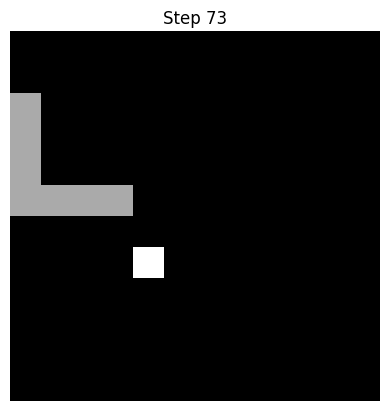

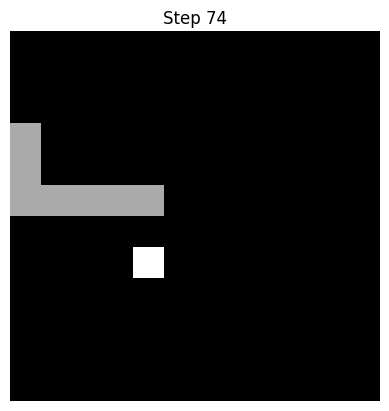

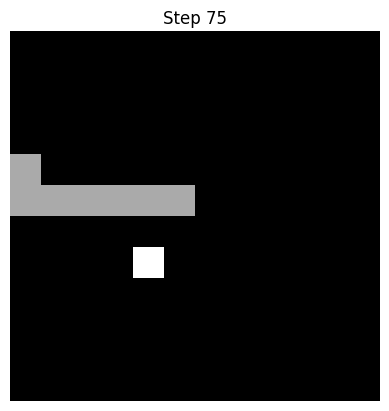

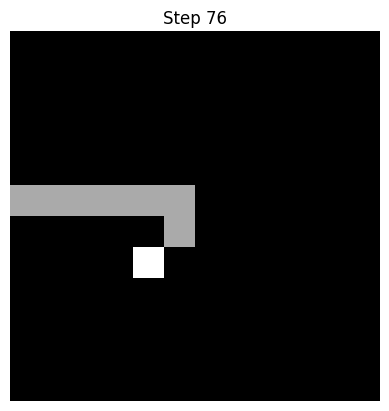

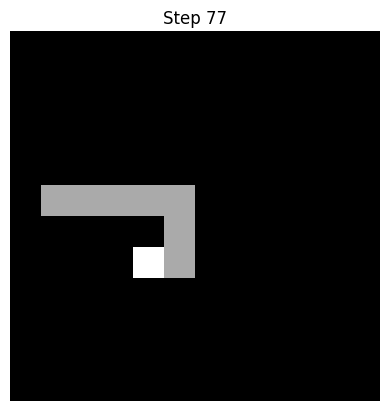

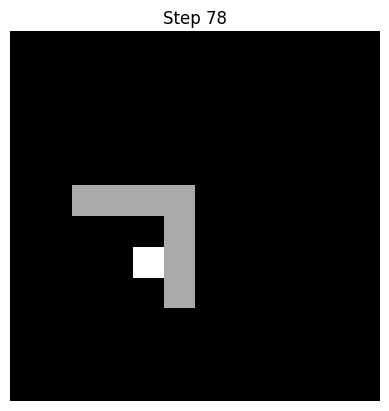

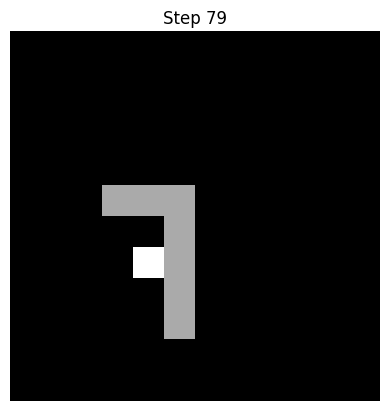

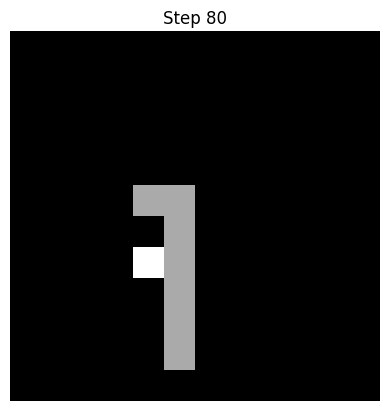

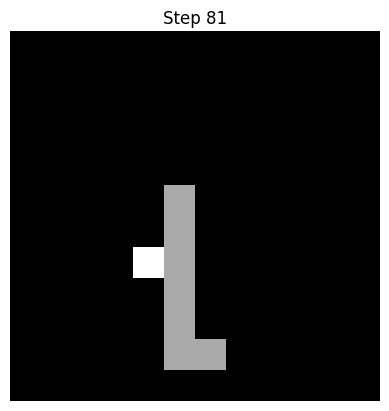

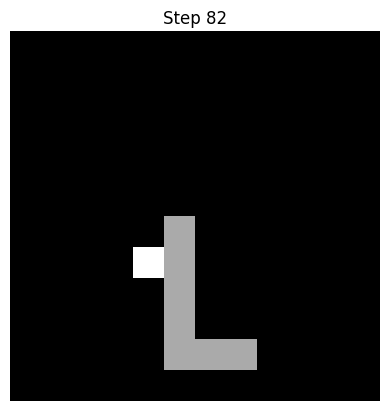

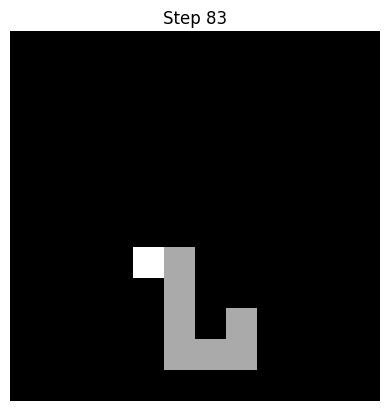

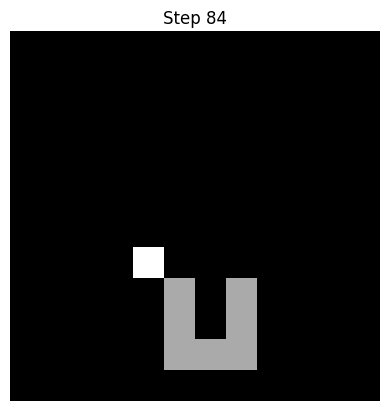

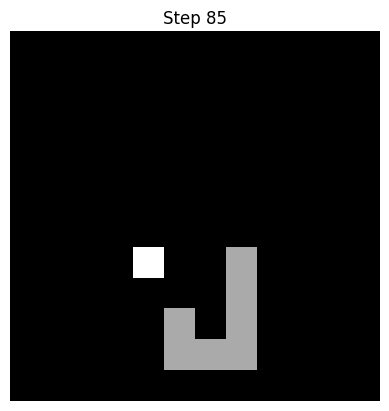

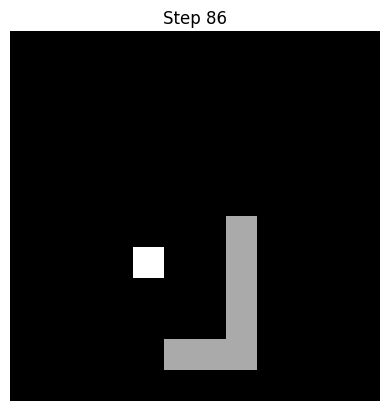

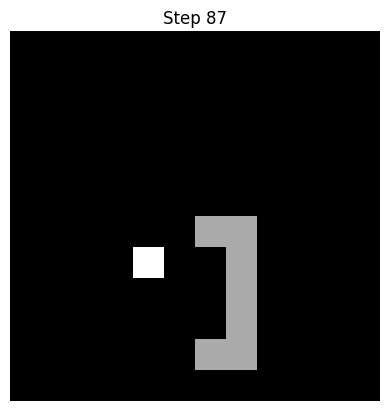

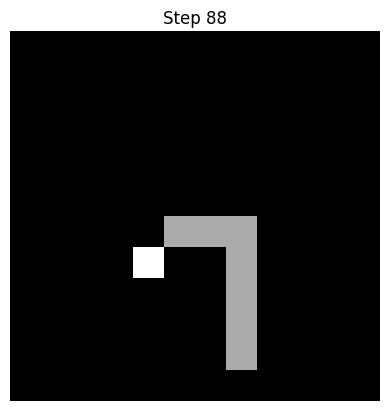

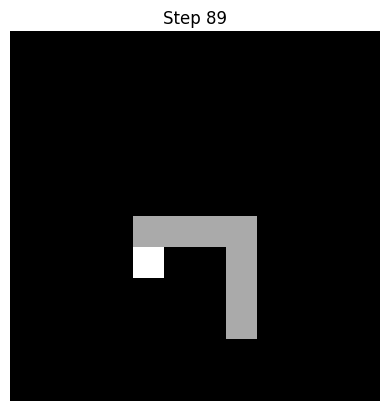

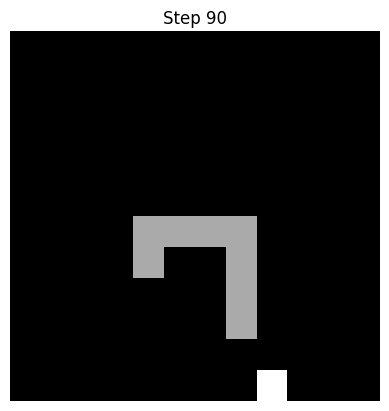

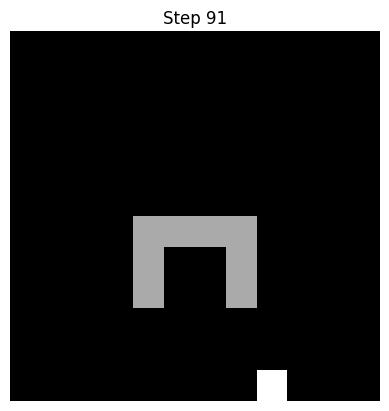

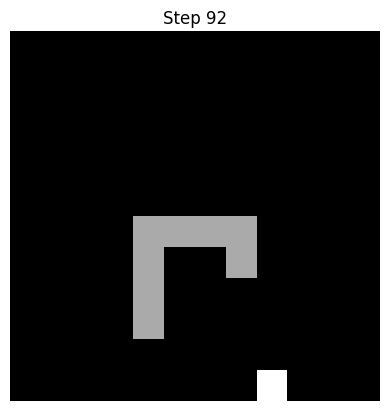

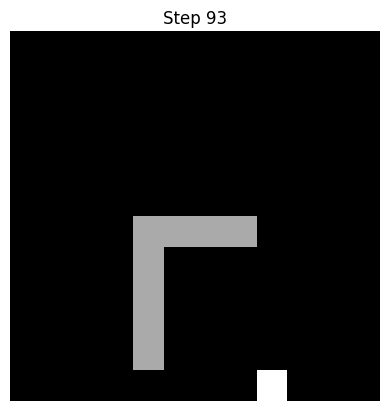

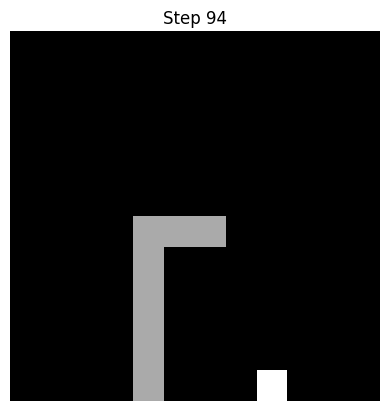

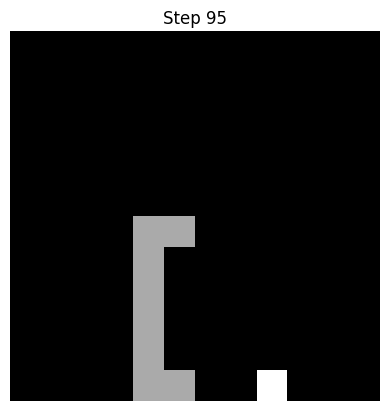

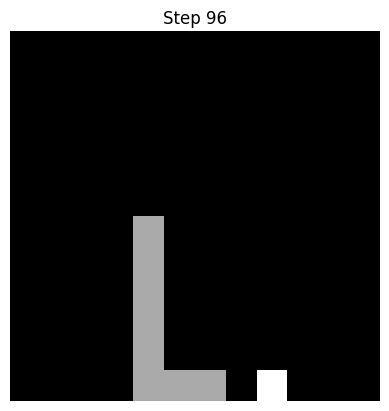

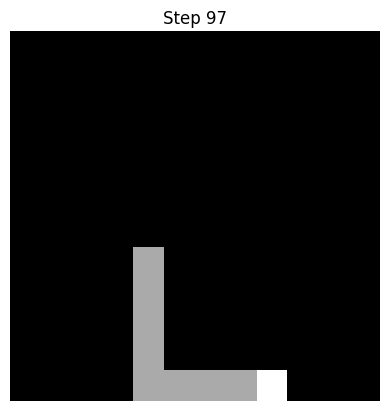

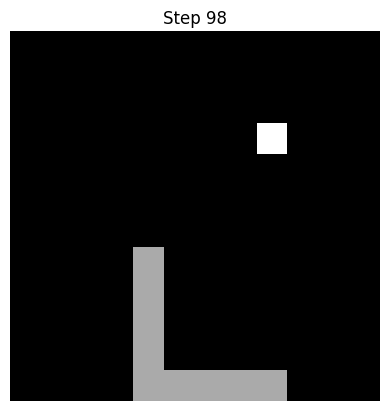

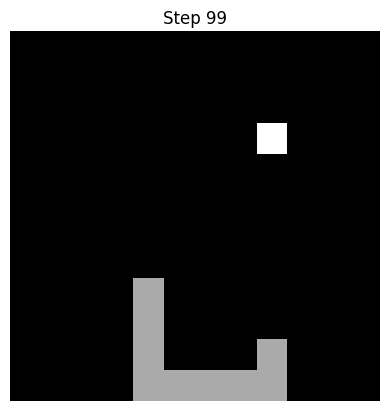

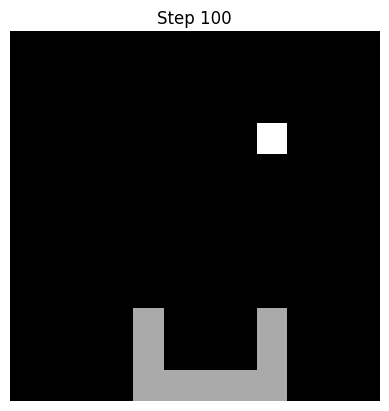

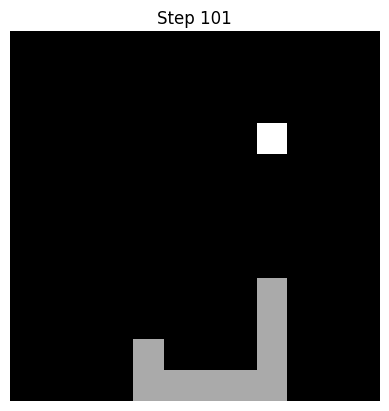

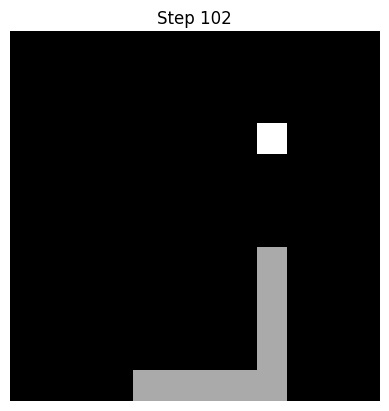

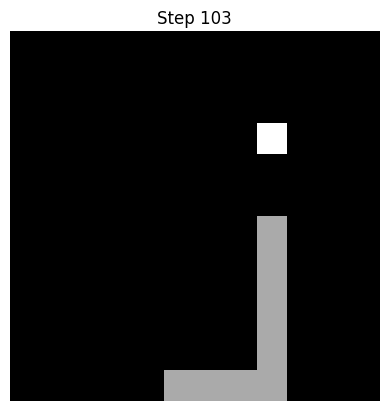

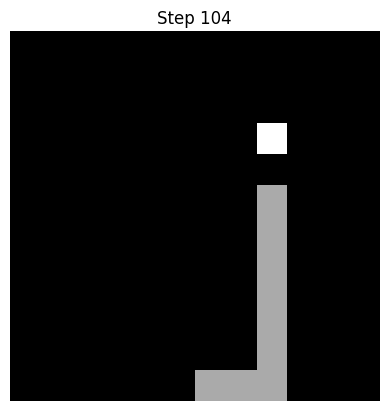

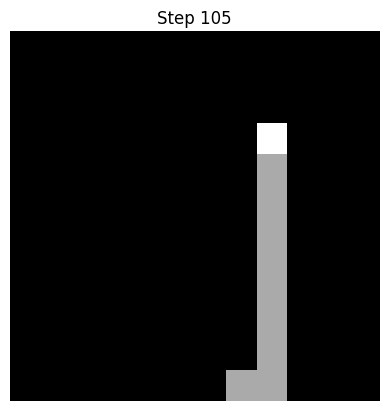

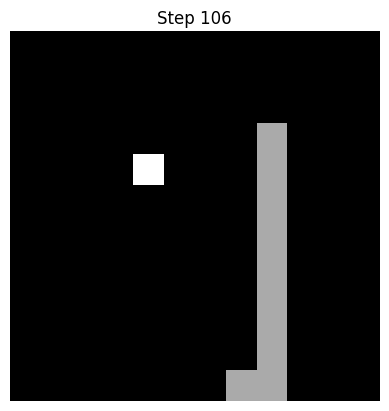

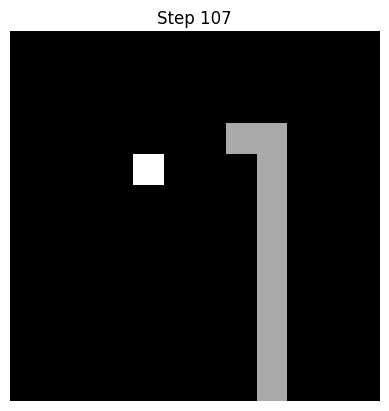

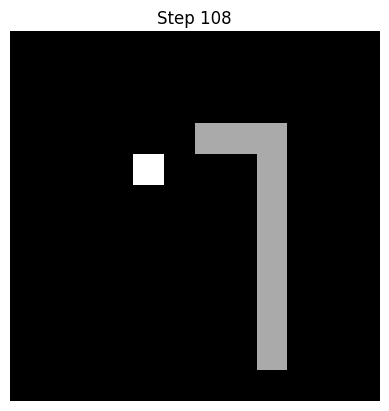

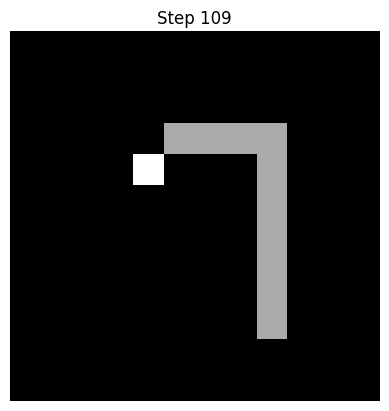

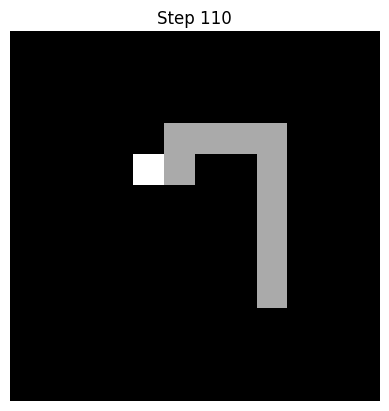

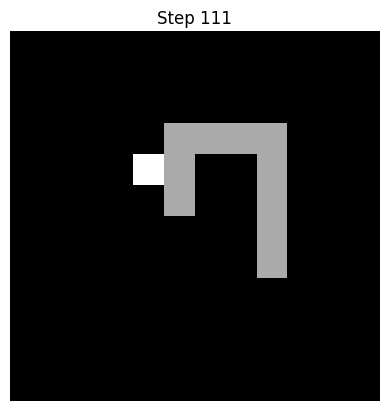

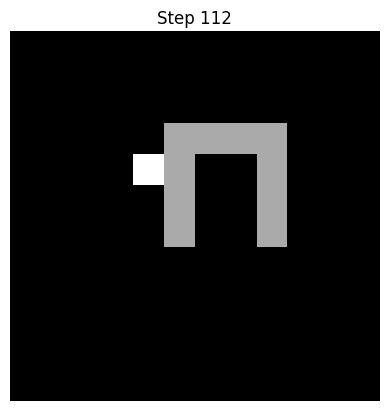

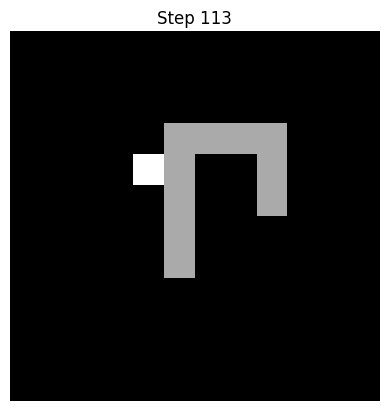

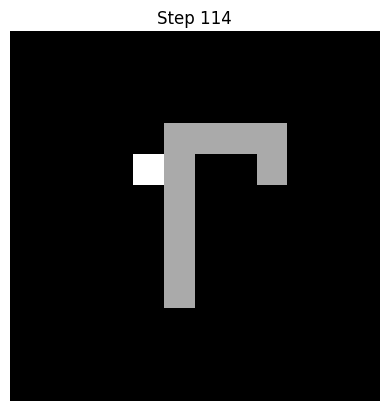

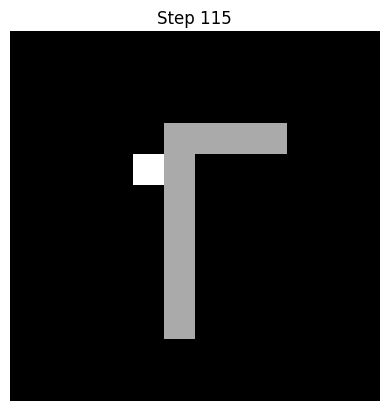

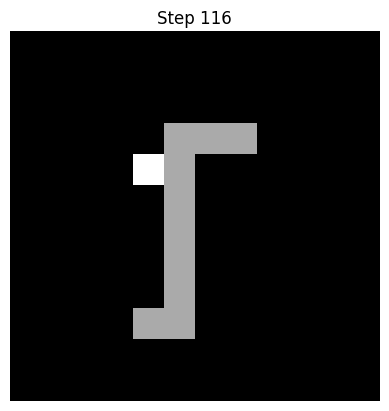

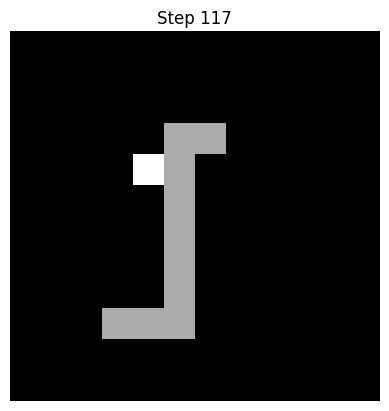

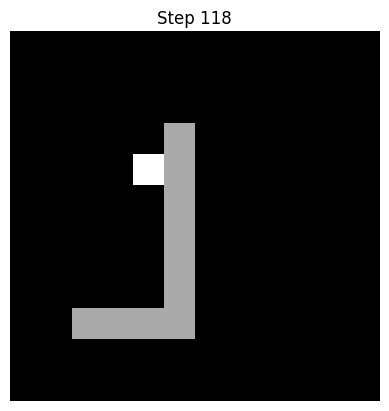

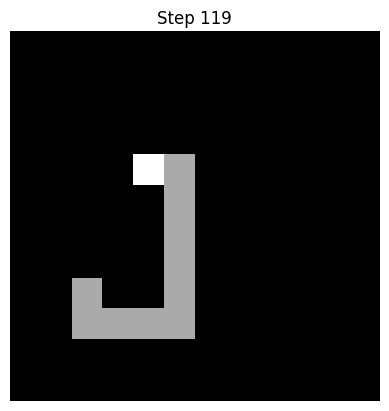

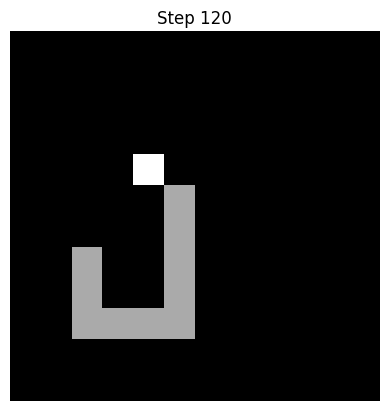

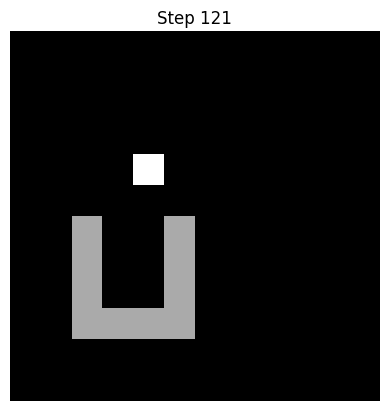

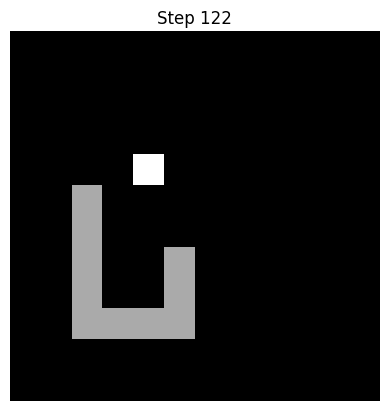

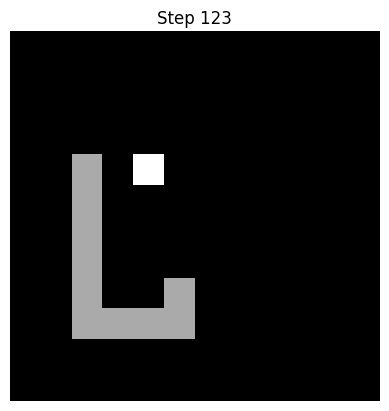

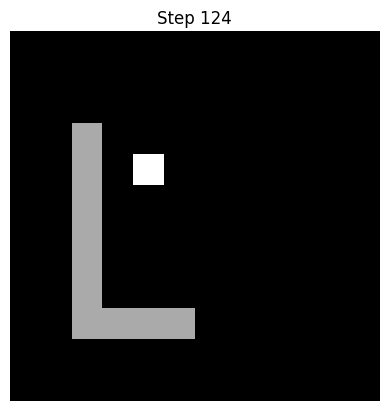

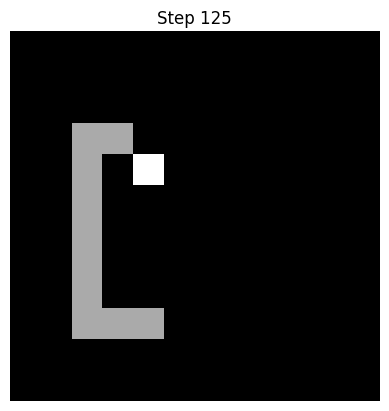

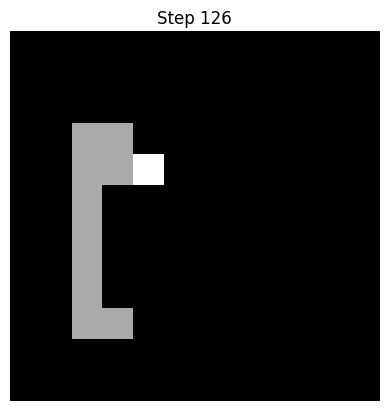

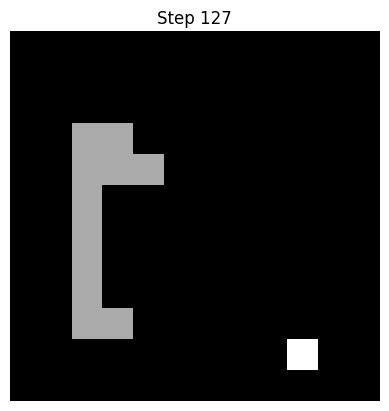

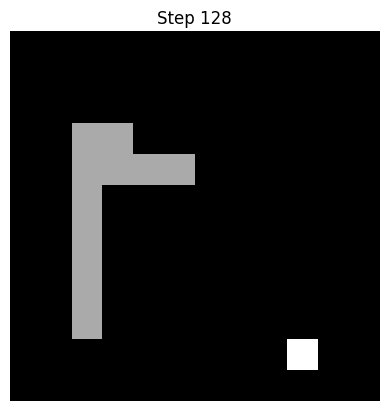

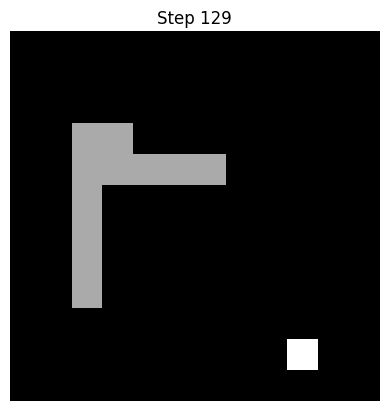

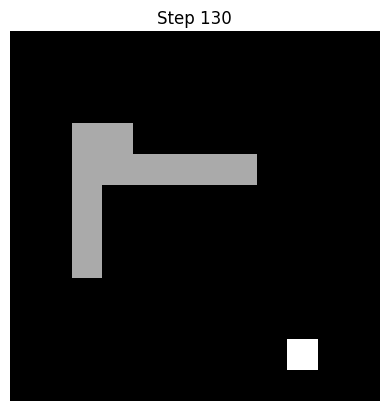

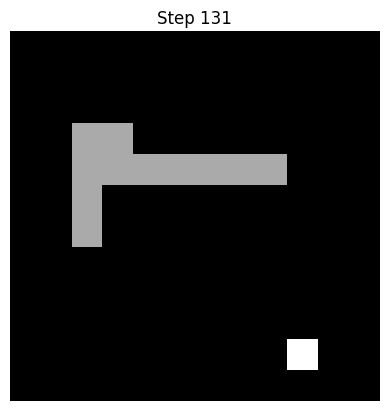

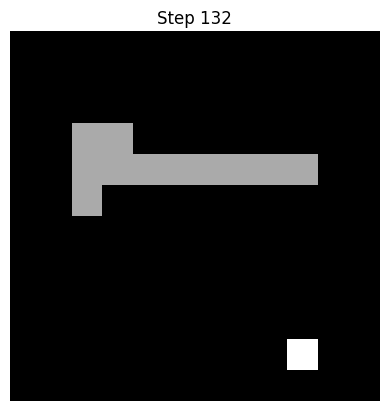

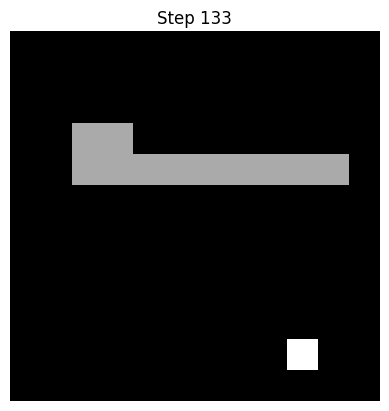

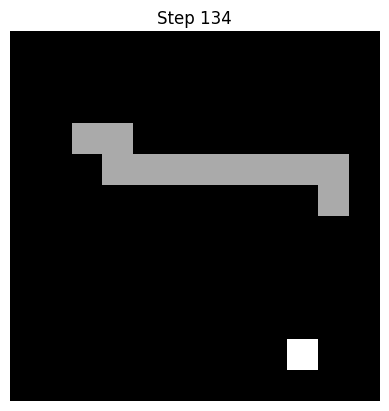

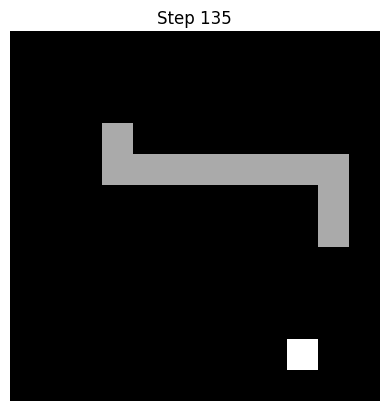

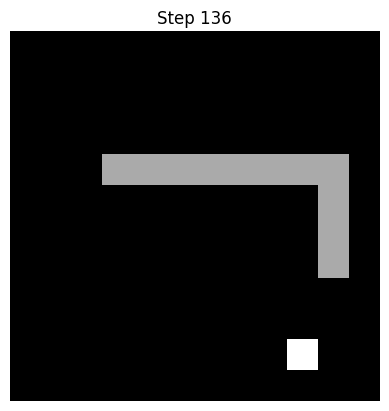

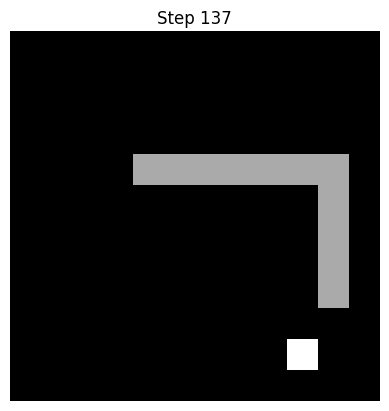

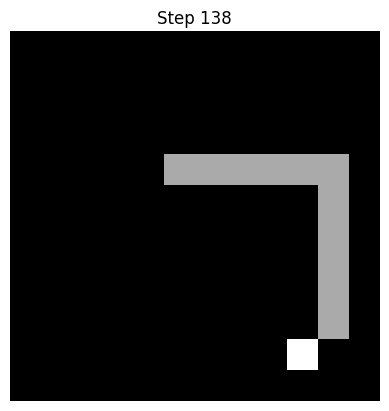

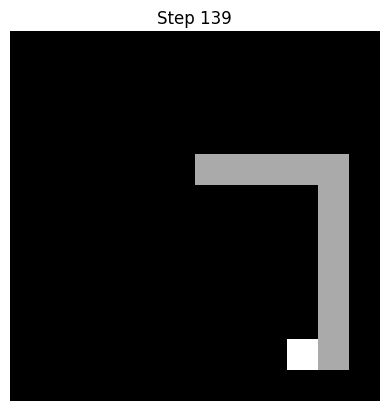

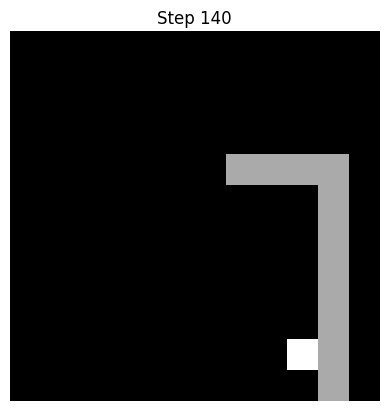

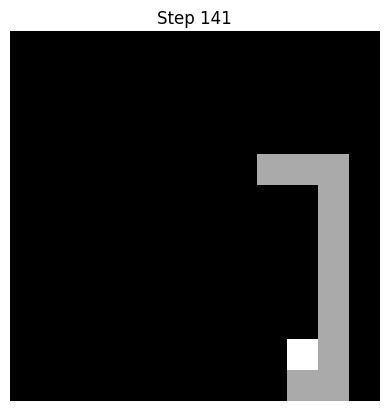

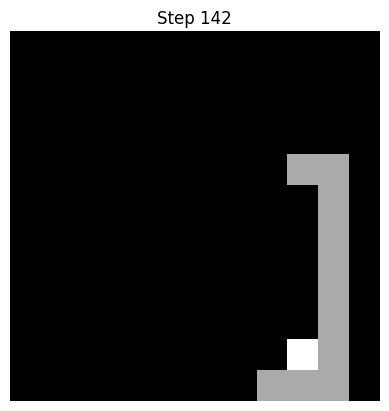

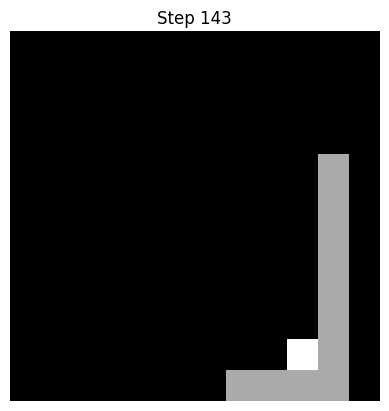

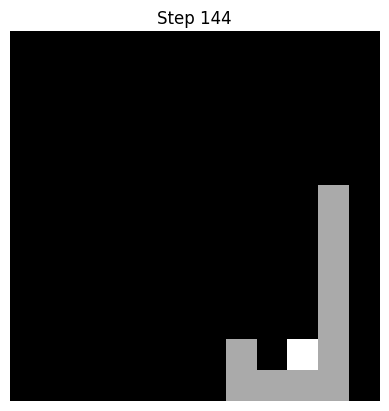

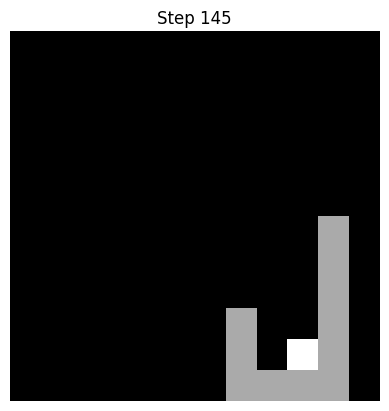

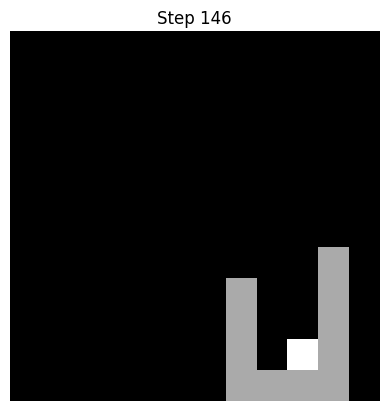

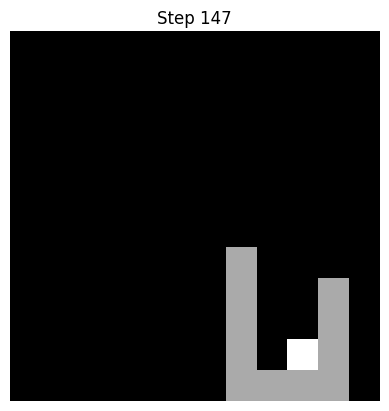

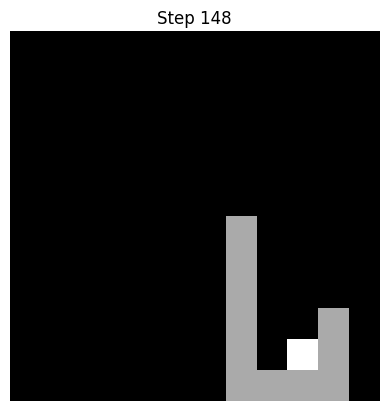

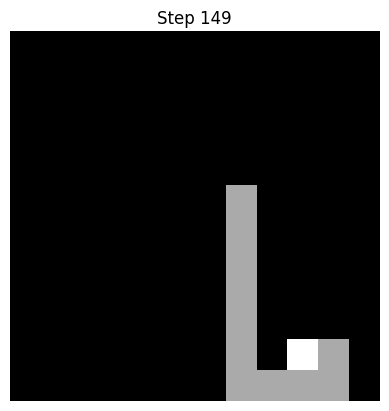

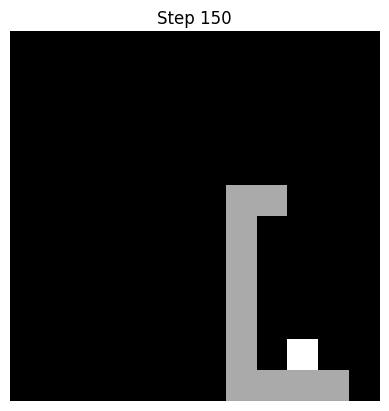

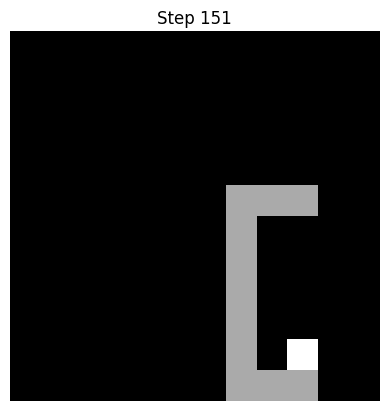

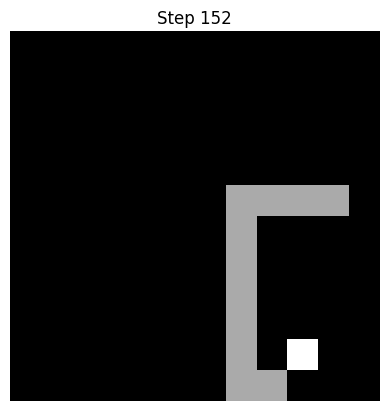

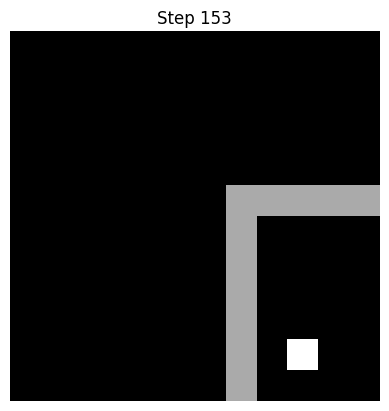

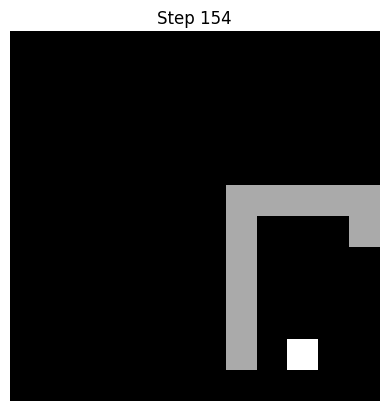

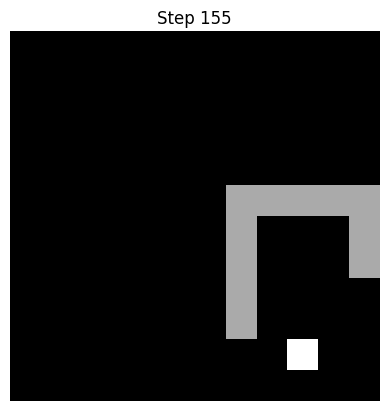

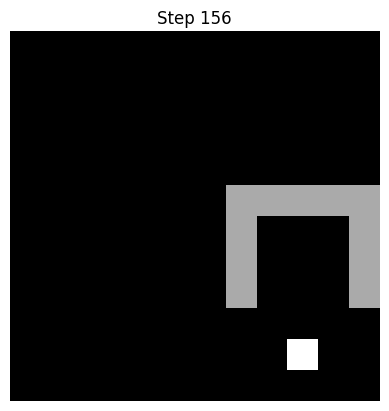

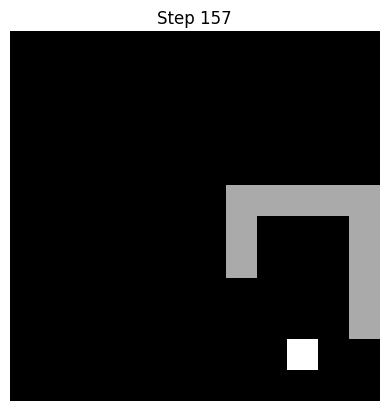

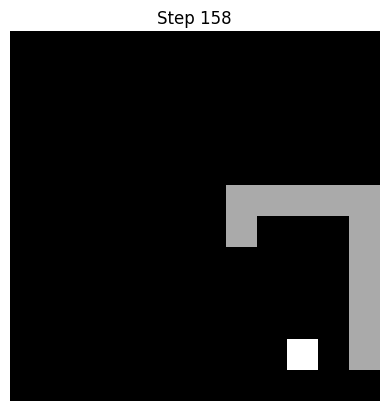

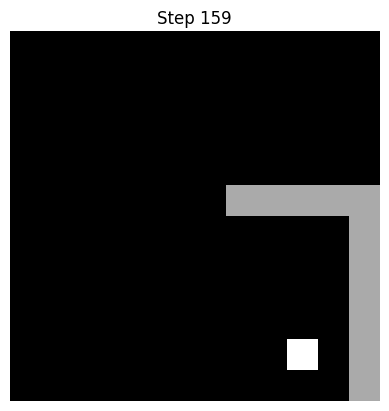

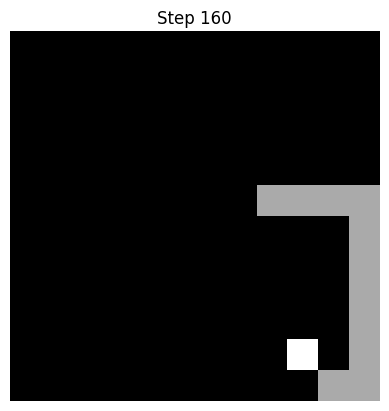

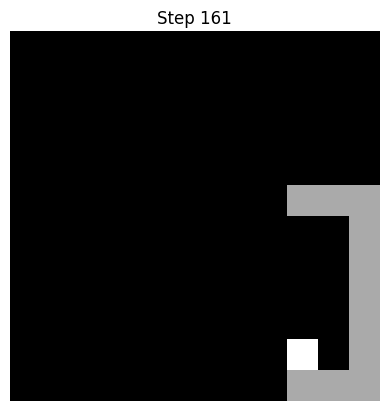

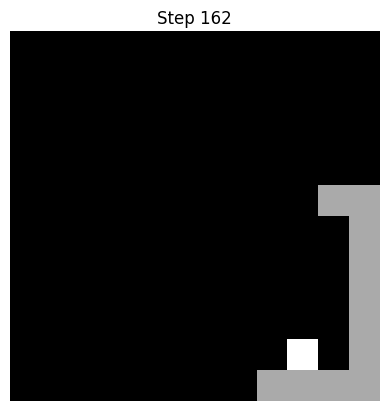

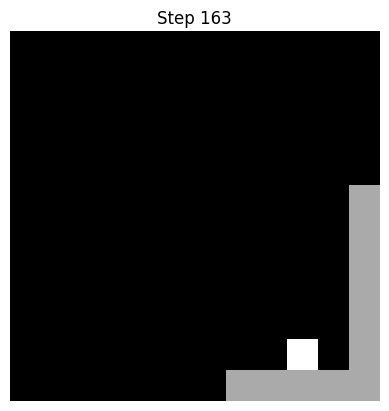

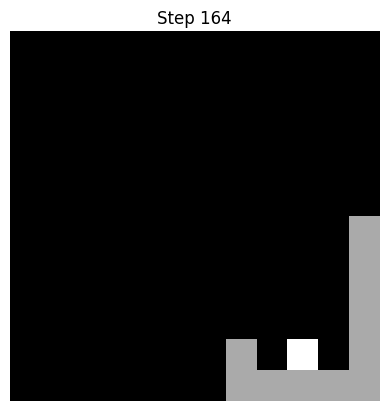

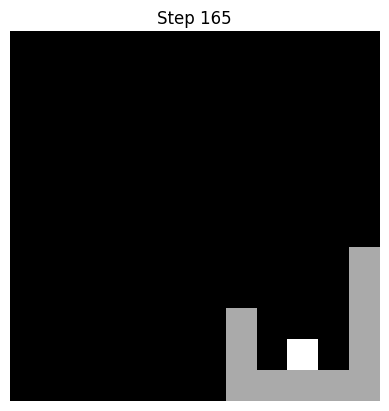

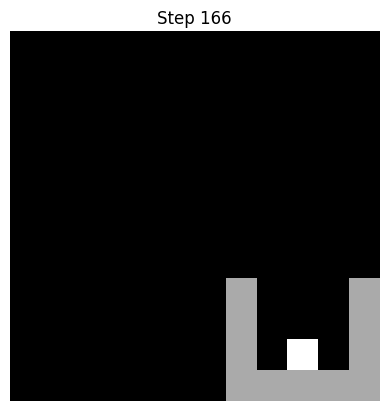

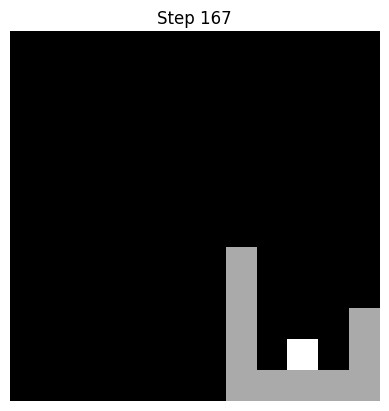

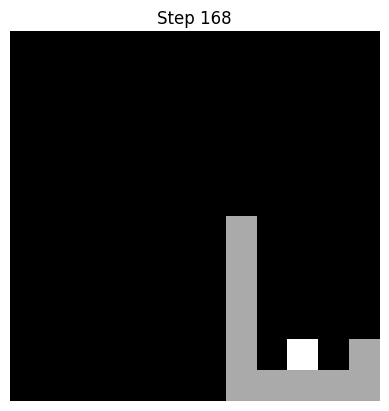

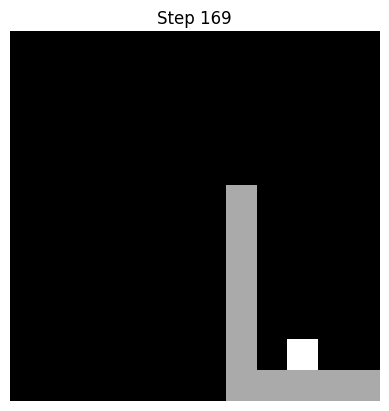

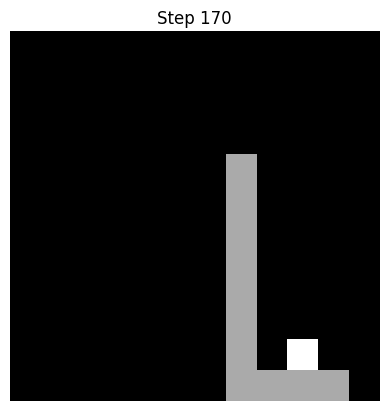

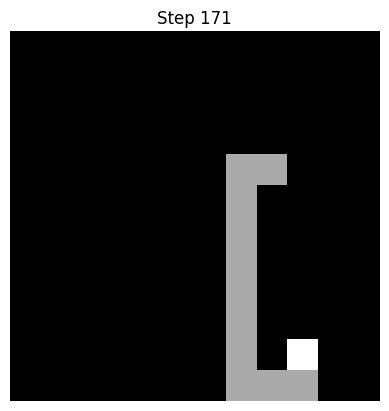

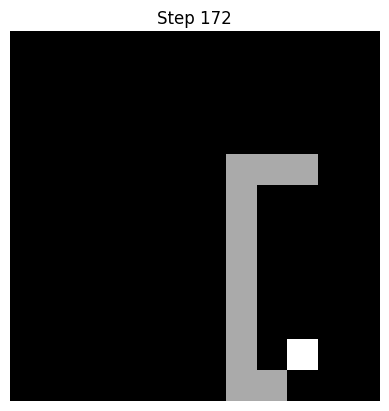

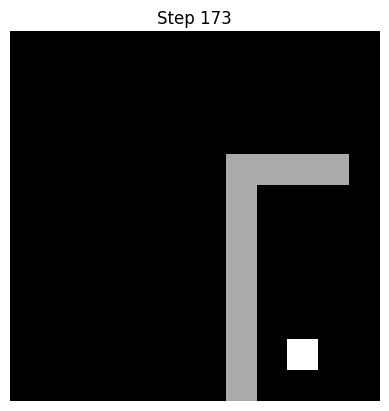

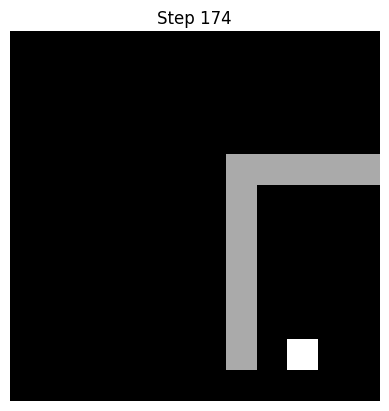

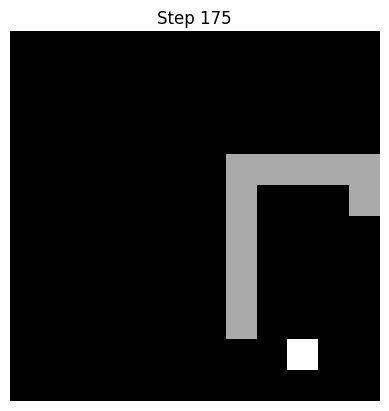

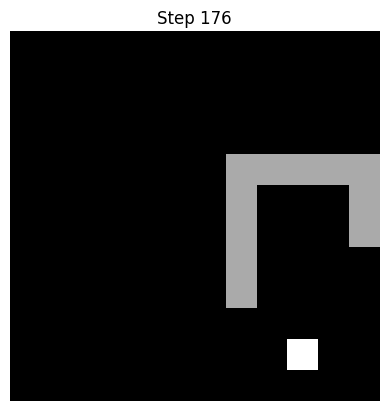

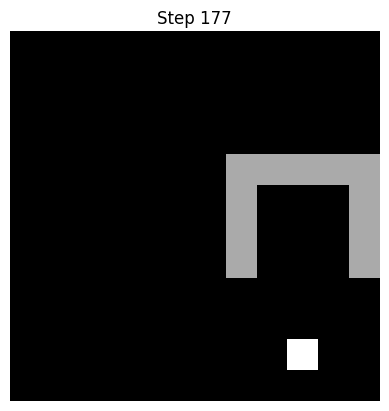

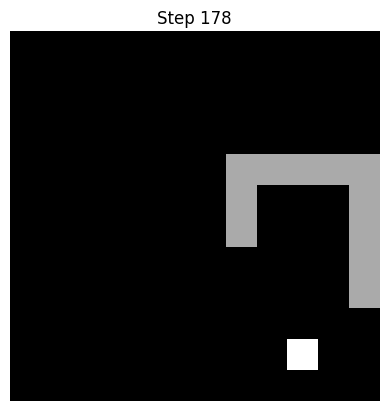

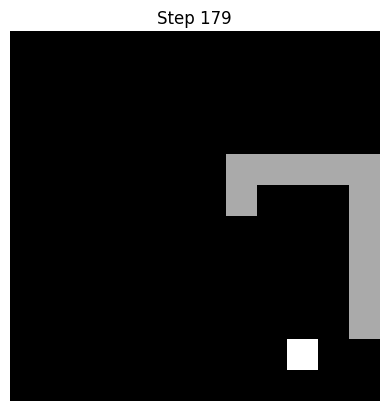

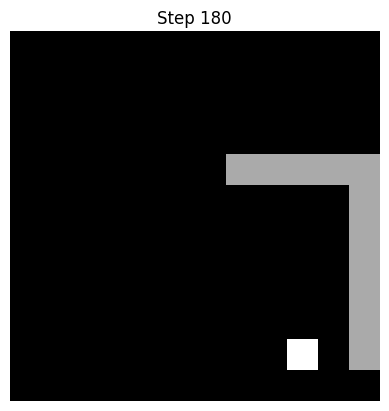

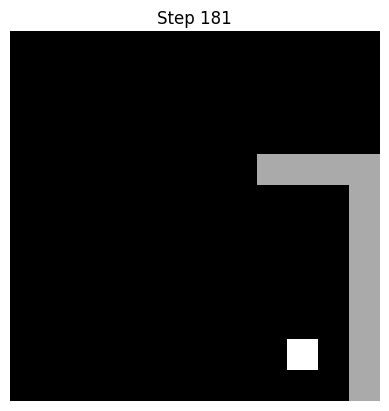

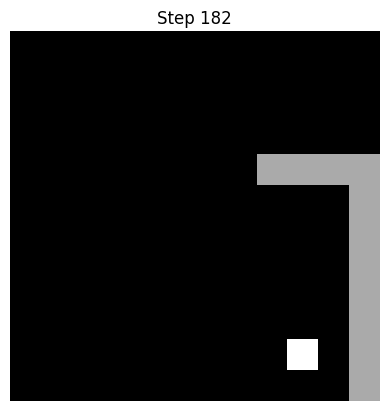

In [32]:
import time
import matplotlib.pyplot as plt

def visualize_gameplay(env, q_network, max_steps=200):
    """Runs one episode of gameplay with the current q_network and displays the state."""
    state = env.reset()
    total_reward = 0
    frames = []  # Store frames for later visualization
    q_network.eval()  # Set the network to evaluation mode

    with torch.no_grad():  # Disable gradient calculations during evaluation
        for t in range(max_steps):
            state_tensor = torch.from_numpy(state.astype(np.float32) / 255.0).unsqueeze(0).unsqueeze(0).to(device)
            q1, q2 = q_network(state_tensor)
            q_values = (q1 + q2) / 2.0
            action = int(torch.argmax(q_values, dim=1).item())

            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            frames.append(env._get_observation())  # Store the current frame
            state = next_state

            if done:
                break

    print(f"Episode finished after {t + 1} steps, total reward: {total_reward:.2f}")

    # Display the collected frames
    for i, frame in enumerate(frames):
        plt.imshow(frame, cmap='gray', interpolation='nearest')
        plt.title(f"Step {i}")
        plt.axis('off')
        plt.show()

# Run gameplay visualization using the loaded model
print("Starting gameplay visualization...")
visualize_gameplay(env, q_network, max_steps=200)

In [33]:
torch.save(q_network.state_dict(), "drq_snake_model_final.pth")
print("Model saved to drq_snake_model_final.pth")

!pip freeze > requirements.txt
print("requirements.txt generated.")

Model saved to drq_snake_model_final.pth
requirements.txt generated.
